In [ ]:
%pip install git+https://github.com/pymc-labs/pymc-marketing.git
%pip install preliz causal-learn dowhy numpyro

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-nfyyj2j9
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-nfyyj2j9
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit 2f101ab93ee277b8e0b28a2a49e3fdd20fb6bd91
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 7.0 MB/s eta 0:00:00


# Introduction to Causal Discovery

In this notebook, we'll dive into how to uncover causal relationships in marketing data, a crucial step for understanding the true impact of various channels on business outcomes. We'll start by generating synthetic data that mimics real-world marketing scenarios, complete with confounding variables and complex causal structures.

Next, we'll fit a Bayesian marketing mix model using PyMC-Marketing, check causal directions between variables, and perform mediation analysis to explore indirect effects. Finally, we'll use structure discovery techniques to infer potential causal graphs. By the end, you'll have a solid grasp of how to apply these techniques to reveal hidden causal insights in your marketing data.

In [ ]:
from pymc_marketing.mmm.transformers import geometric_adstock, michaelis_menten

from pymc_marketing.mmm import MMM, GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.prior import Prior

import networkx as nx
from graphviz import Digraph
import pydot

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.display import SVG, display

import numpy as np
import pandas as pd

import preliz as pz
import pymc as pm

from PIL import Image
from io import BytesIO

from causallearn.graph.Endpoint import Endpoint
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.ConstraintBased.PC import pc

In [ ]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams.update({"figure.constrained_layout.use": True})

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [ ]:
seed = sum(map(ord, "Estimating effects despite having Confounding Variables"))
rng = np.random.default_rng(seed)

In [ ]:
print(seed)
print(rng)

5395
Generator(PCG64)


# Business case

As a company we probably invest in different channels to acquire new customers. Some actions are more direct, like paid ads, and others are more indirect, like offline media marketing, as marketers and scientist, we want to understand the impact of each channel on the target variable (number of new customers).


The following DAG shows a possible causal structure of the problem. Let's say we have the following variables:

- $x1$: offline ads, e.g. TV, radio, print, etc.
- $x2$: digital ads, e.g. SEM, SEO, social media, etc.
- $x3$: internal marketing, e.g. product marketing, internal communication, etc.
- $y$: new users

Its probable that our offline ads are not directly affecting our new users, but they are affecting our digital ads and internal marketing, users observe a banner of our product and then they search for it online or they are referred by a friend which finally converts using their phone. Independently, some digital ads can impact users which haven't heard of us before, and those could convert directly.

On top of that, we have some external factors that could affect our new users, e.g. holidays, economic conditions, etc. Things like holidays could affect even more our digital ads, e.g. more users are online shopping, and we are investing more during those days as well.

This creates a complex causal structure, where variables are not fully independent and it is not easy to infer the causal impact of each channel on the target variable.

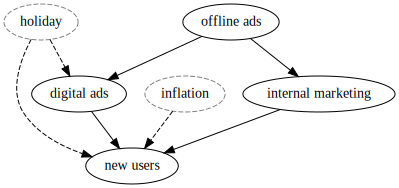

In [ ]:
new_real_dag = Digraph(comment='DAG')

new_real_dag.node('z', 'holiday', color='grey', style='dashed')
new_real_dag.node('m', 'inflation', color='grey', style='dashed')
new_real_dag.node('x1', 'offline ads')
new_real_dag.node('x2', 'digital ads')
new_real_dag.node('x3', 'internal marketing')
new_real_dag.node('y', 'new users')

new_real_dag.edge('z', 'x2', style='dashed')

new_real_dag.edge('x1', 'x2')
new_real_dag.edge('x1', 'x3')

new_real_dag.edge('z', 'y', style='dashed')
new_real_dag.edge('x2', 'y')
new_real_dag.edge('x3', 'y')
new_real_dag.edge('m', 'y', style='dashed')

new_real_dag

## Data generation

Based on the provided DAG, we can create some synthetic data to test how our model performs when we have a complex causal structures. Using the same data, we can test different model compositions and see how could we improve our model to uncover the true causal impact of each channel on the target variable.

We'll start by setting the date range. Here we'll use a date range from 2022-01-01 to 2024-11-06, meaning we have almost 3 years of data (1041 days).

In [ ]:
# date range
min_date = pd.to_datetime("2022-01-01")
max_date = pd.to_datetime("2024-11-06")
date_range = pd.date_range(start=min_date, end=max_date, freq="D")

df = pd.DataFrame(data={"date_week": date_range}).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 1041


### Holiday signal

Certain holidays, like Christmas, can have a significant impact on consumer behavior before and after the specific date, leading to seasonal spikes in sales. To capture these effects, we introduce a holiday signal based on Gaussian (normal) distributions centered around specific holiday dates.

The function used to model the holiday effect is defined as follows:

$$
H_{t} = \exp\left(-0.5 \left(\frac{\Delta t}{\sigma}\right)^2\right)
$$

Where:
- $\Delta t$ is the time difference (in days) between the current date and the holiday date.
- $\sigma$ is the standard deviation that controls the spread of the effect around the holiday date.

For each holiday, we calculate the holiday signal across the date range and add a **holiday contribution** by scaling the signal with a holiday-specific coefficient. This approach models seasonal holiday spikes using Gaussian functions, which capture the transient increase in market activity around holidays, and their respective decay over time.

> Note: Here we assume a normally distributed signal, nevertheless the signal could be skew or not normal distributed.

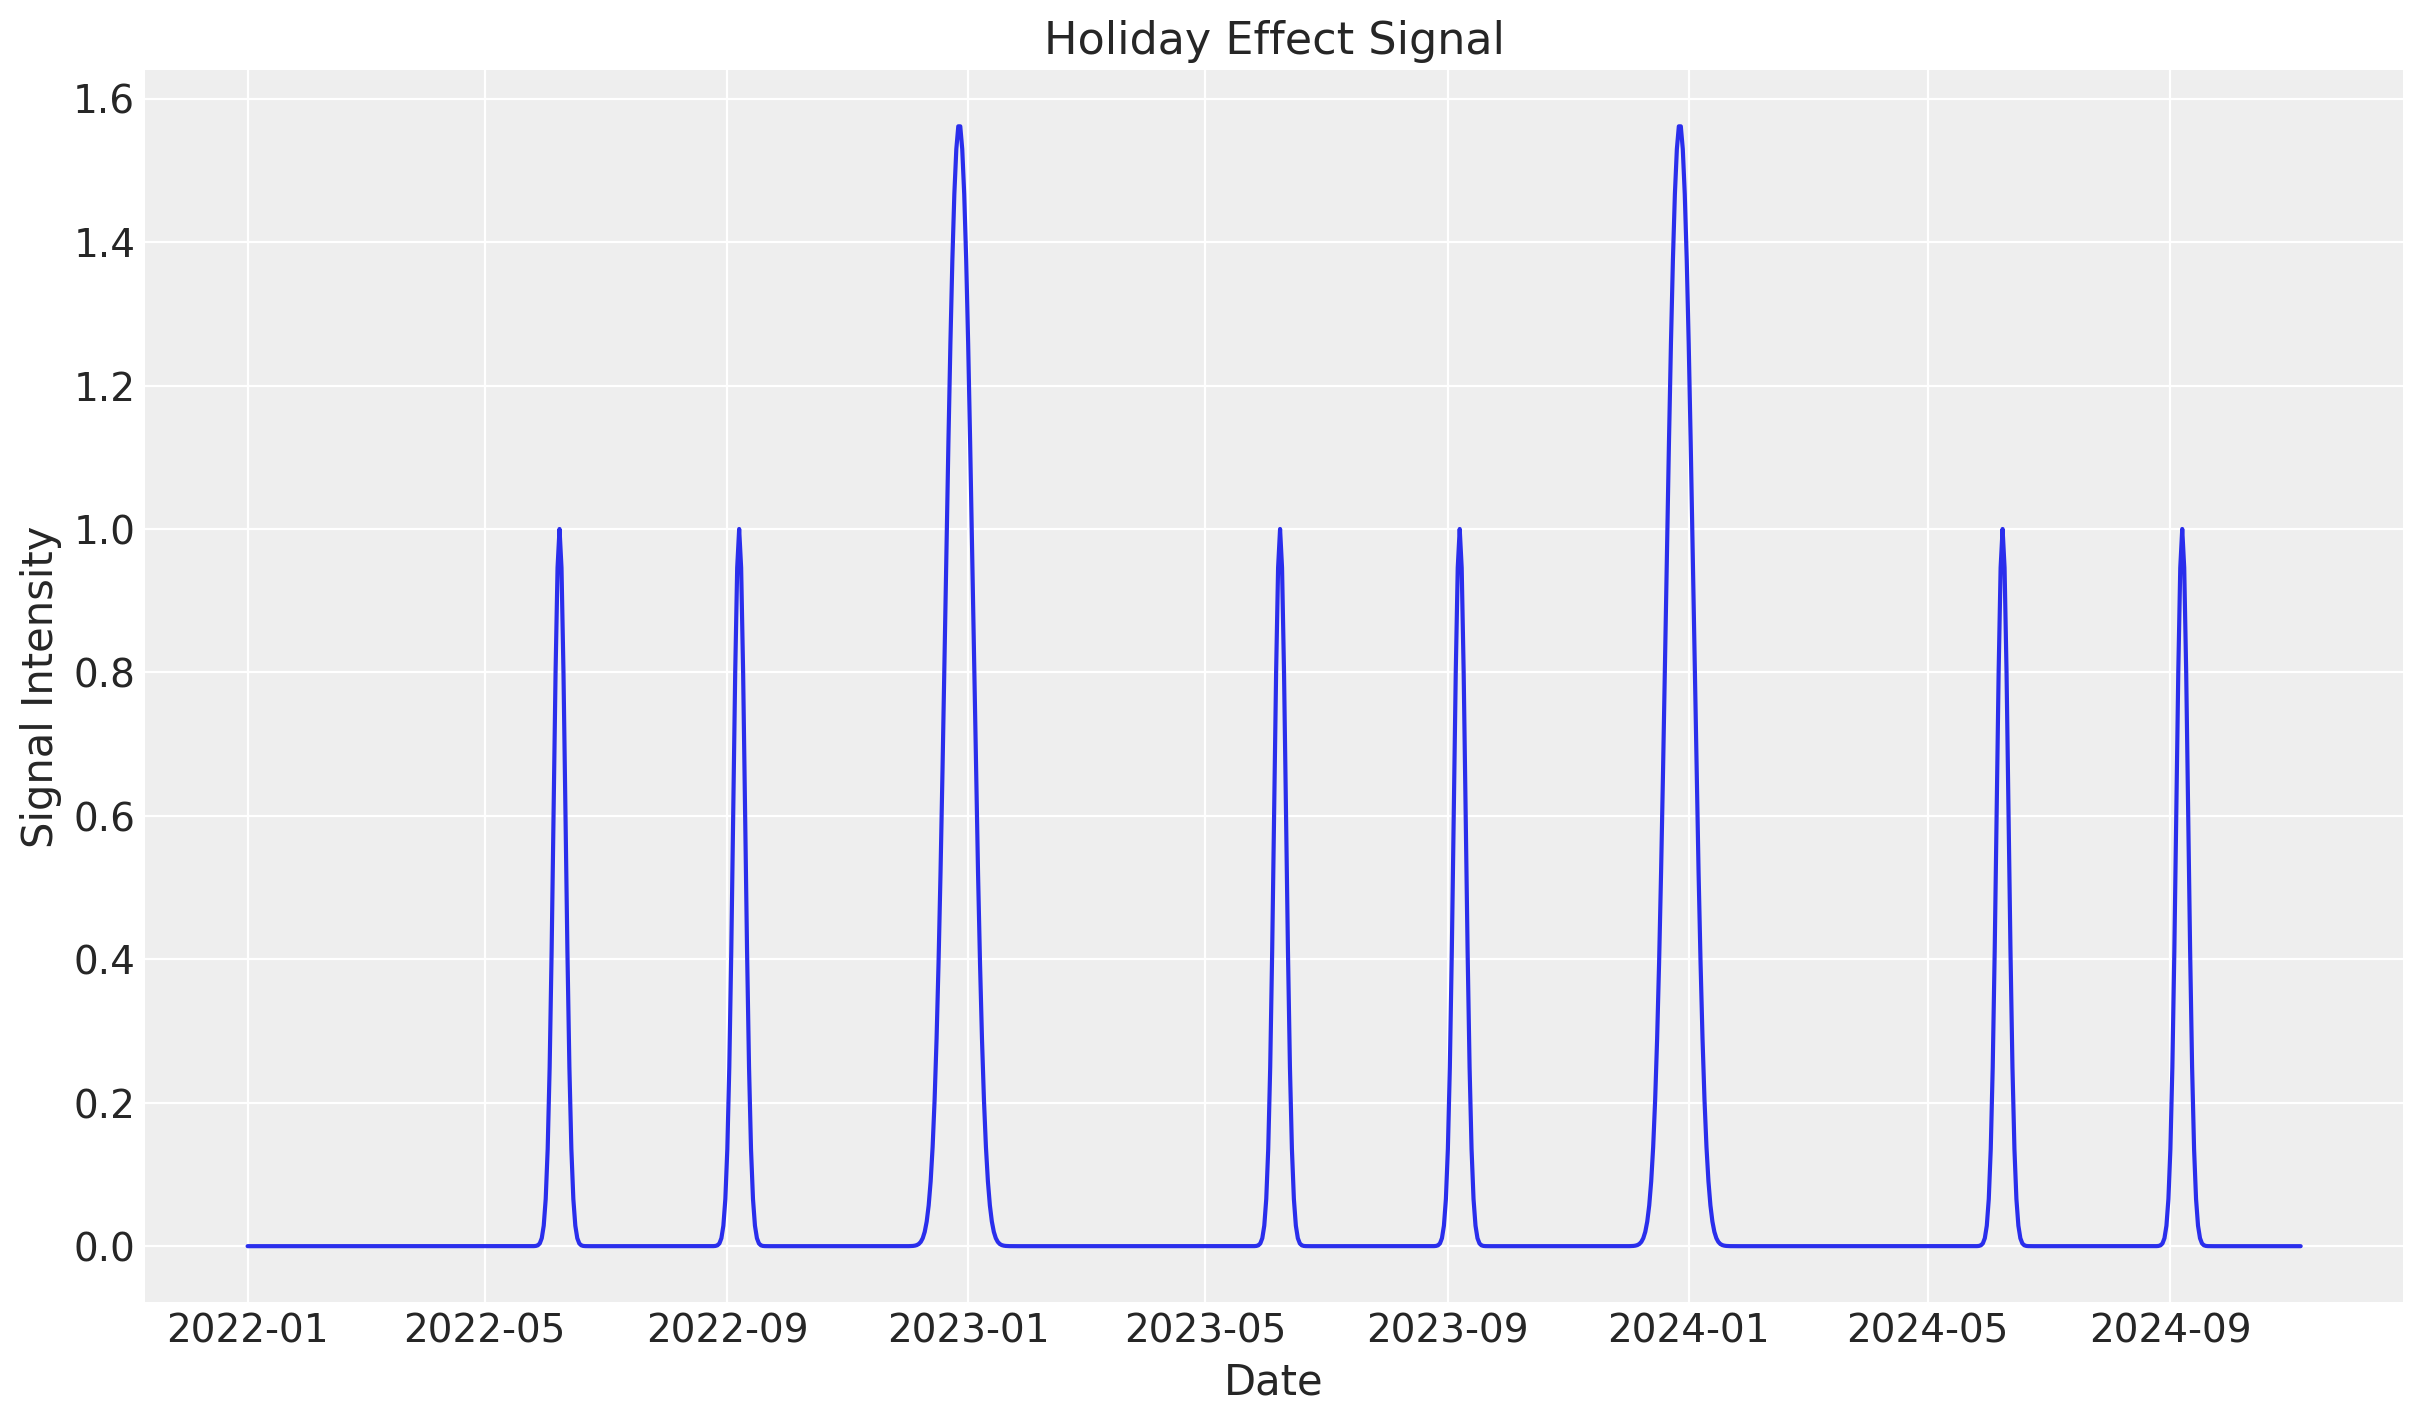

In [ ]:
holiday_dates = ["24-12", "31-12", "08-06", "07-09"]  # List of holidays as month-day strings
std_devs = [5, 5, 3, 3]  # List of standard deviations for each holiday
holidays_coefficients = [2, 3, 4, 6]

# Initialize the holiday effect array
holiday_signal = np.zeros(len(date_range))
holiday_contributions = np.zeros(len(date_range))

# Generate holiday signals
for holiday, std_dev, holiday_coef in zip(
    holiday_dates, std_devs, holidays_coefficients, strict=False
):
    # Find all occurrences of the holiday in the date range
    holiday_occurrences = date_range[date_range.strftime("%d-%m") == holiday]

    for occurrence in holiday_occurrences:
        # Calculate the time difference in days
        time_diff = (date_range - occurrence).days

        # Generate the Gaussian basis for the holiday
        _holiday_signal = np.exp(-0.5 * (time_diff / std_dev) ** 2)

        # Add the holiday signal to the holiday effect
        holiday_signal += _holiday_signal

        holiday_contributions += _holiday_signal * holiday_coef

df["holiday_signal"] = holiday_signal
df["holiday_contributions"] = holiday_contributions

# Plot the holiday effect
fig, ax = plt.subplots()
sns.lineplot(x=date_range, y=holiday_signal, ax=ax)
ax.set(title="Holiday Effect Signal", xlabel="Date", ylabel="Signal Intensity")
plt.show()

### Generating inflation
Next, we generate the data for **Inflation**. We assume the inflation follows a power-law trend, meaning that growth accelerates over time rather than remaining constant. This can be mathematically defined as:

$$
IN_{t} = (t + \text{baseline})^{\text{exponent}} - 1
$$

Where:
- $t$: The time index, representing days since the start of the date range.
- $baseline$: A constant added to $t$ to shift the starting point of the trend. This value affects the initial level of market growth. The starting value of the function will be $(baseline)^{exponent} - 1$, not 0.
- $exponent$: The power to which the time index is raised, determining the rate at which the trend accelerates over time.

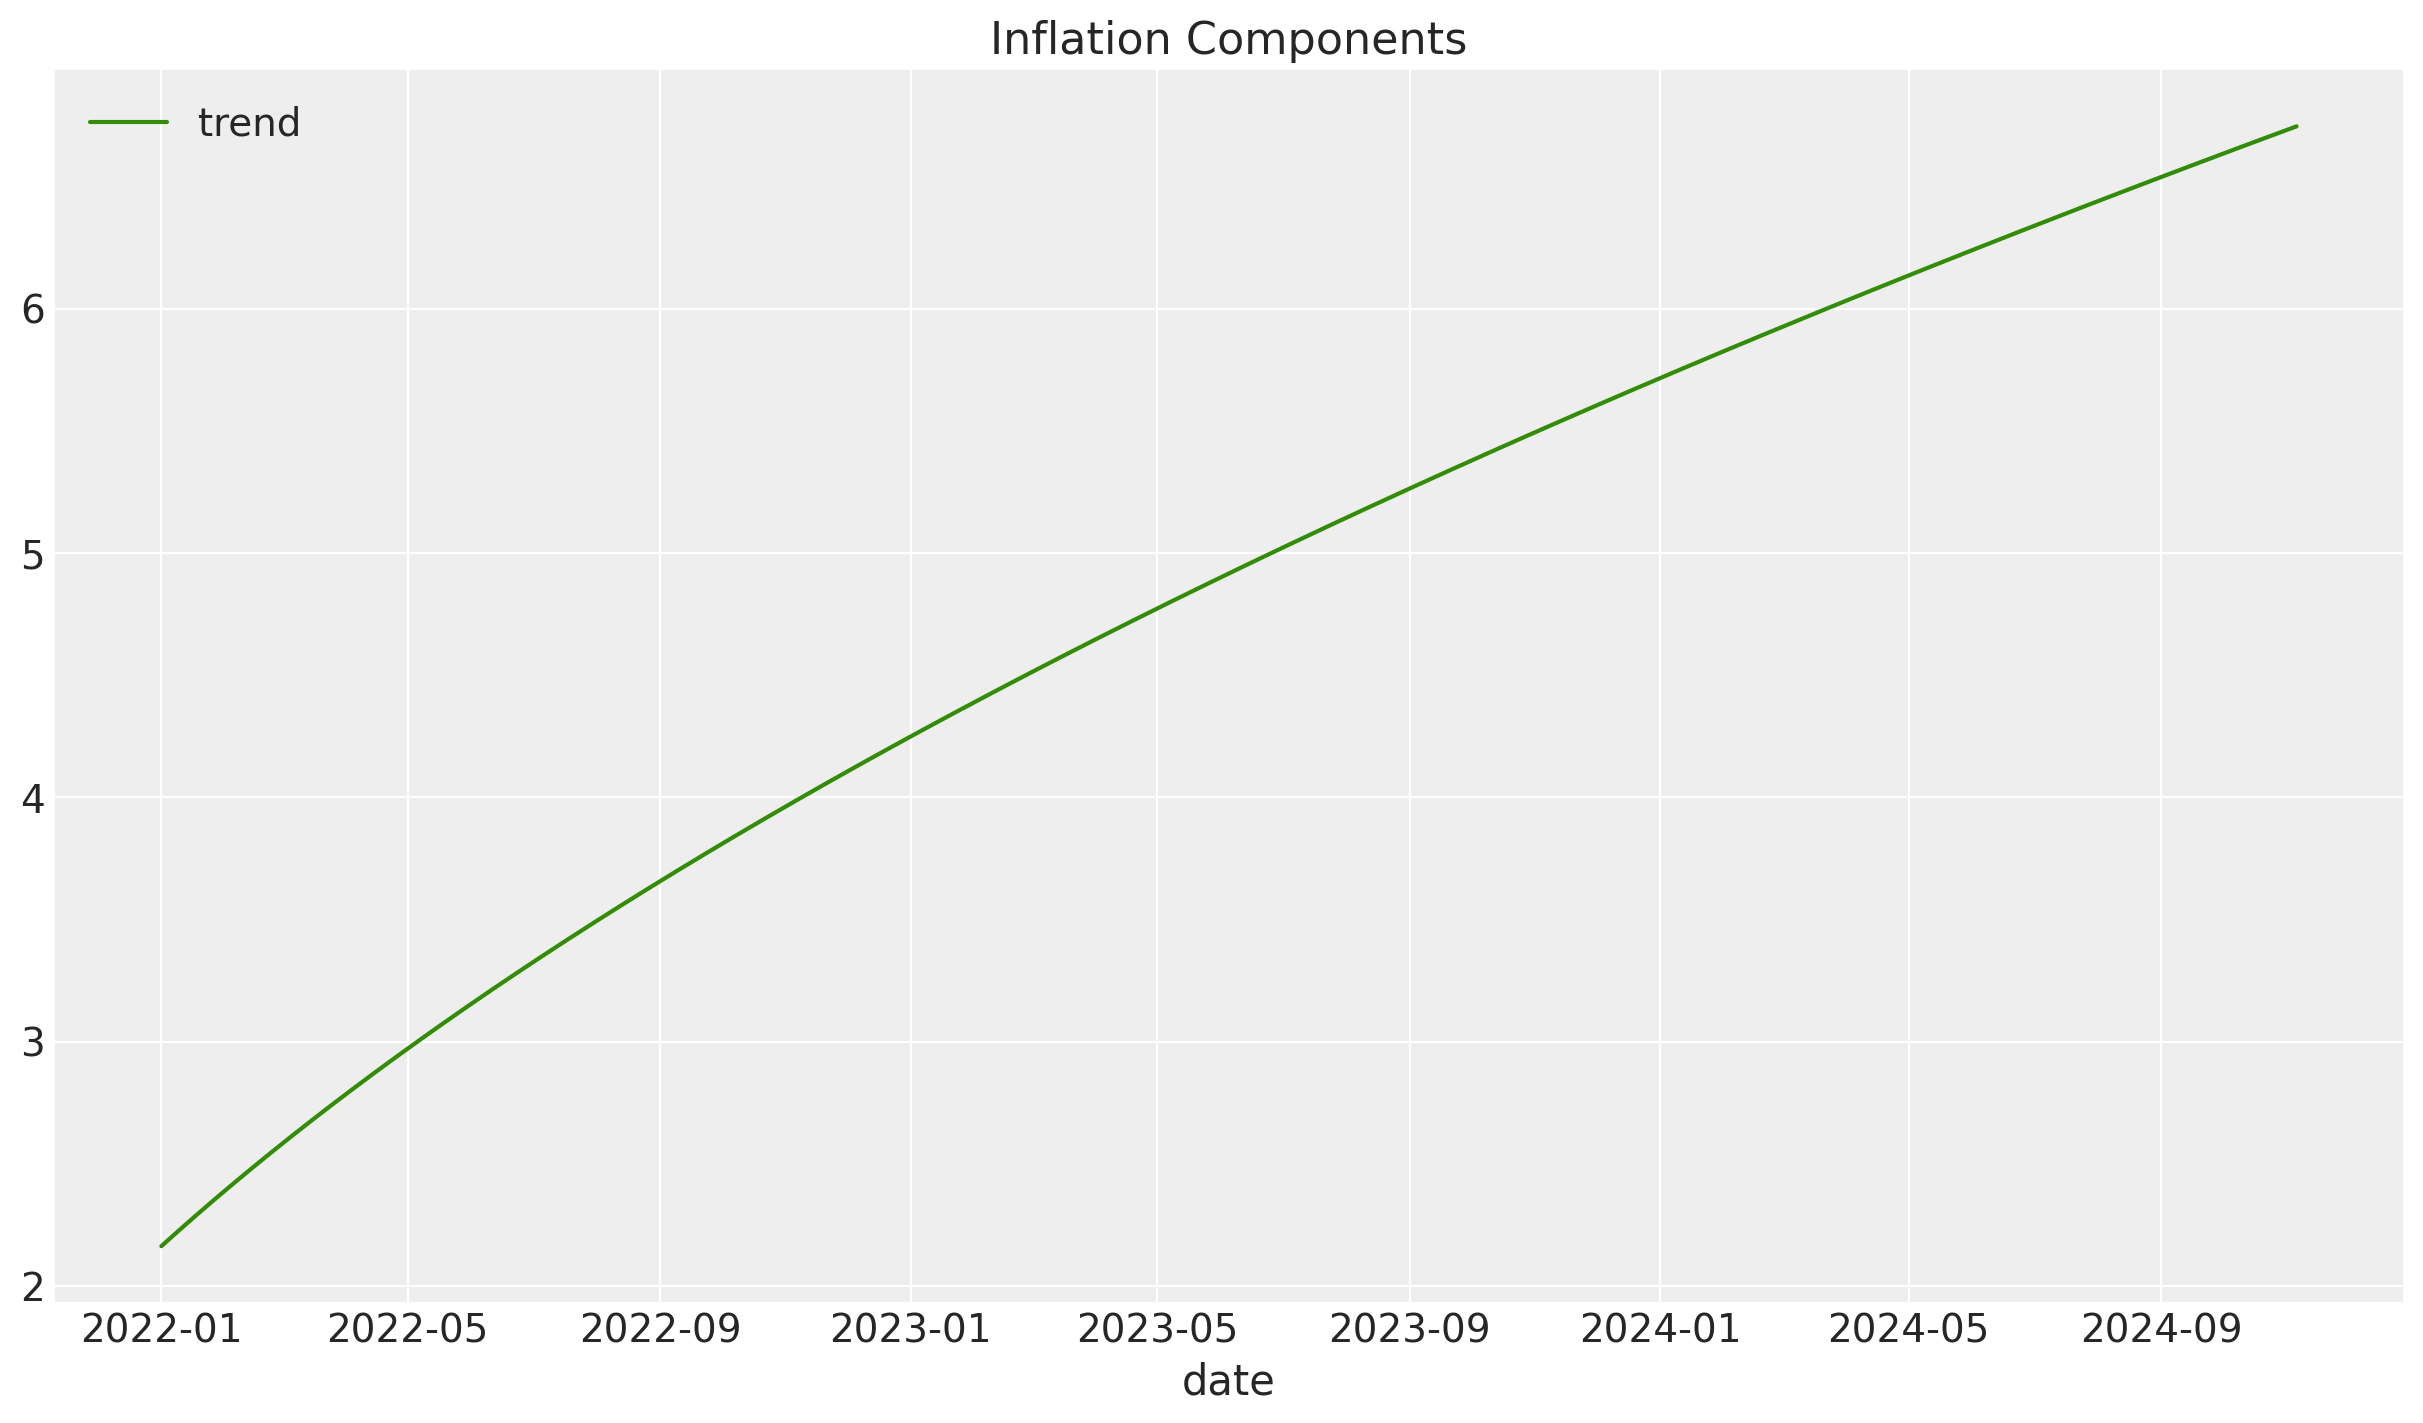

In [ ]:
df["inflation"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (2 / 4) - 1

fig, ax = plt.subplots()
sns.lineplot(
    x="date_week", y="inflation", color="C2", label="trend", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Inflation Components", xlabel="date", ylabel=None);

### Modeling Marketing Channels

In this section, we simulate three marketing channels, $x1$, $x2$, and $x3$ which represent different advertising channels (e.g., Internal Marketing, Social Marketing, Offline Marketing). Each channel's behavior is influenced by random variability and confounding effects from seasonal holidays. Here’s how we model each channel mathematically:

**Channel $x1$**:
As mentioned before, we generate $x1$ which is affected by the holiday signal, we could define it as:

$$
I_{x1_t} = S_{x1_t} + e_{x1}
$$

**Channel $x2$**:
On the other hand, we generate $x2$ which is affected by the holiday signal, and the influence of $x1$. We could define it as:

$$
I_{x2_t} = S_{x2_t} + H_{t} \times \alpha_{x2} + (I_{x1_t} \times \alpha_{x1_x2}) + e_{x2}
$$

**Channel $x3$**:
For the last variable, we generate $x3$ which is affected by $x1$ only.

$$
I_{x3_t} = S_{x3_t} + (I_{x1_t} \times \alpha_{x1_x3}) + e_{x3}
$$

These equations allow us to capture the complex dynamics influencing each marketing channel:
- **Holiday Effects** increase channel activity around specific dates, simulating seasonal spikes.
- **Cross-channel Influences** introduce interdependencies, modeling how one channel's success can amplify another’s.

> Note: Here we are assuming an additive impact for the channel interactions.

In [ ]:
x1 = pz.Gamma(mu=1, sigma=3).rvs(n, random_state=rng)
cofounder_effect_holiday_x1 = 2.5
x1_conv = np.convolve(x1, np.ones(14) / 14, mode="same")
noise = pz.Normal(mu=0, sigma=0.1).rvs(28, random_state=rng)
x1_conv[:14] = x1_conv.mean() + noise[:14]
x1_conv[-14:] = x1_conv.mean() + noise[14:]
df["x1"] = x1_conv

x2 = pz.Gamma(mu=2, sigma=2).rvs(n, random_state=rng)
cofounder_effect_holiday_x2 = 2.2
cofounder_effect_x1_x2 = 1.3
x2_conv = np.convolve(x2, np.ones(18) / 12, mode="same")
noise = pz.Normal(mu=0, sigma=0.1).rvs(28, random_state=rng)
x2_conv[:14] = x2_conv.mean() + noise[:14]
x2_conv[-14:] = x2_conv.mean() + noise[14:]
df["x2"] = (
    x2_conv
    + (holiday_signal * cofounder_effect_holiday_x2)
    + (df["x1"] * cofounder_effect_x1_x2)
) # digital ads

x3 = pz.Gamma(mu=5, sigma=1).rvs(n, random_state=rng)
cofounder_effect_x1_x3 = 1.5
x3_conv = np.convolve(x3, np.ones(16) / 10, mode="same")
noise = pz.Normal(mu=0, sigma=0.1).rvs(28, random_state=rng)
x3_conv[:14] = x3_conv.mean() + noise[:14]
x3_conv[-14:] = x3_conv.mean() + noise[14:]
df["x3"] = (
    x3_conv
    + (df["x1"] * cofounder_effect_x1_x3)
) # internal marketing

We'll assume all of marketing activities suffer the same transformations Adstock and Saturation. This means, each channel will have individual parameters for the selected transformations, in this case Geometrick adstock and michaelis menten.

In [ ]:
# apply geometric adstock transformation
alpha2: float = 0.4
alpha3: float = 0.3

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=24, normalize=True)
    .eval()
    .flatten()
)

df["x3_adstock"] = (
    geometric_adstock(x=df["x3"].to_numpy(), alpha=alpha3, l_max=24, normalize=True)
    .eval()
    .flatten()
)


# apply saturation transformation
lam2: float = 6.0
lam3: float = 12.0

alpha_mm2: float = 12
alpha_mm3: float = 18

df["x2_adstock_saturated"] = michaelis_menten(
    x=df["x2_adstock"].to_numpy(), lam=lam2, alpha=alpha_mm2
)

df["x3_adstock_saturated"] = michaelis_menten(
    x=df["x3_adstock"].to_numpy(), lam=lam3, alpha=alpha_mm3
)

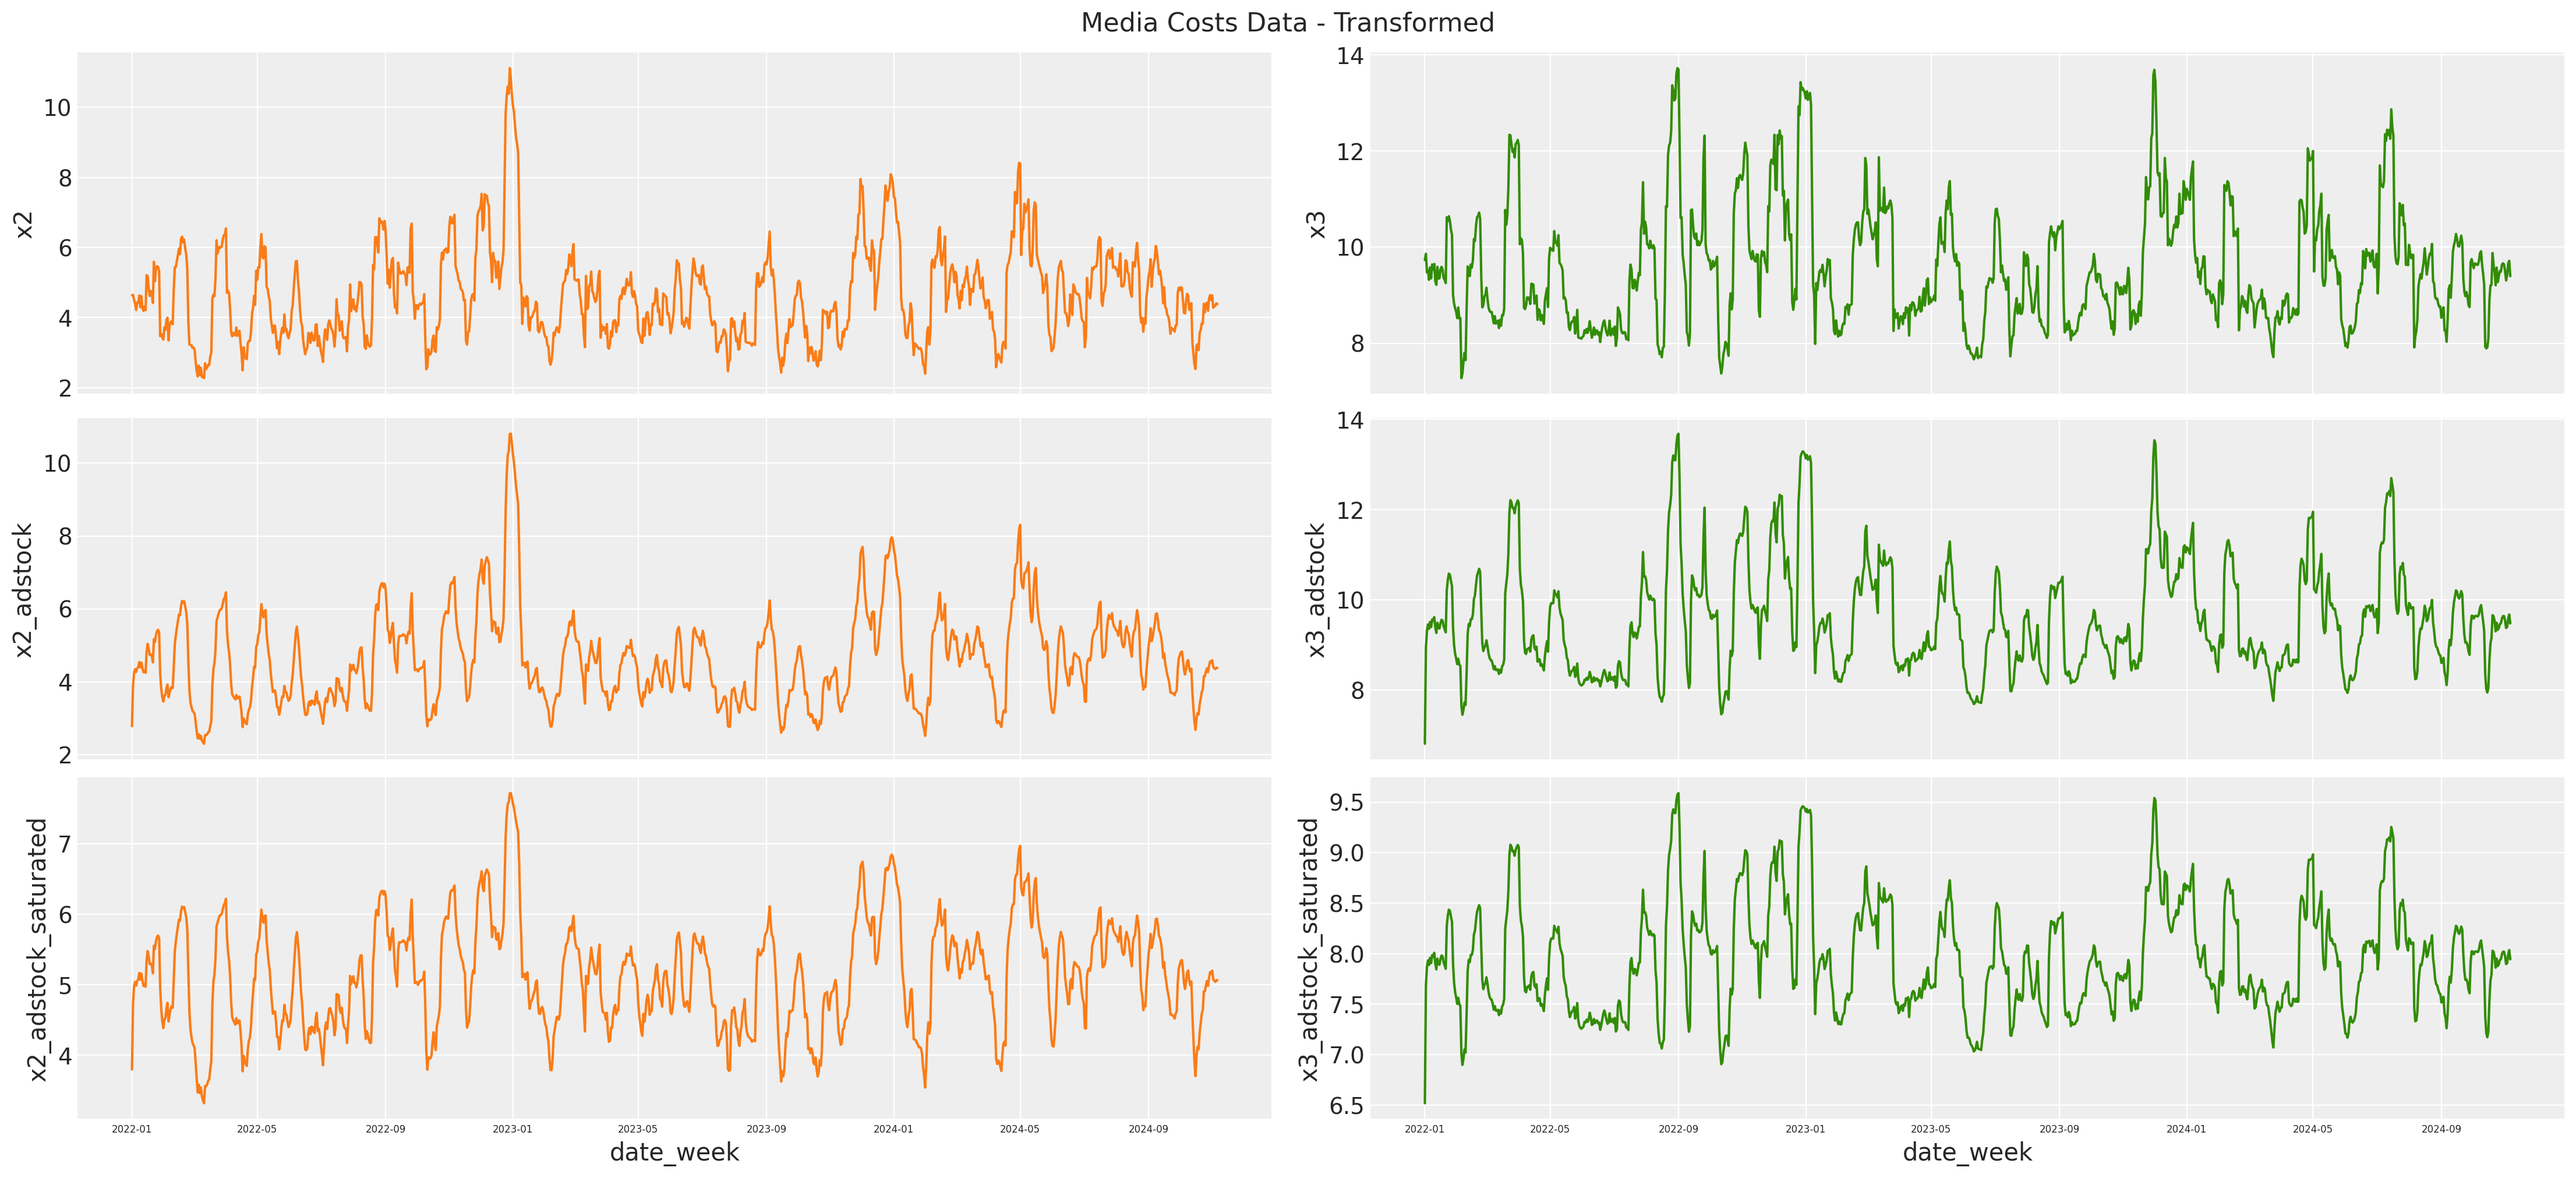

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(22, 10), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x3", data=df, color="C2", ax=ax[0, 1])

sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x3_adstock", data=df, color="C2", ax=ax[1, 1])

sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x3_adstock_saturated", data=df, color="C2", ax=ax[2, 1])

fig.suptitle("Media Costs Data - Transformed", fontsize=16)
# adjust size of X axis
ax[2, 0].tick_params(axis="x", labelsize=8)
ax[2, 1].tick_params(axis="x", labelsize=8)

# adjust size of x axis labels
for ax in ax.flat:
    ax.tick_params(axis="x", labelsize=6)

The previous plot shows how the transformations affect each variable, and what would be the true contribution after each transformation.

### Target variable
The target variable is a combination of all variables before. The mathematical formula can be expressed as:

$$
y_{t} = Intercept - f(IN_{t}) + f(H_{t}) + m(I_{x3_t}) + m(I_{x2_t}) + \epsilon
$$

Where:
- **Intercept**: A baseline level of sales, set to 1.5, representing the base sales level in the absence of other effects.
- **Inflation**: Represents the underlying market inflation, with an implicit negative coefficient of 1, adding a steady downward influence.
- **Holiday Contributions**: Adds sales spikes around holiday periods, capturing the seasonal increase in consumer demand.
- **$m(Impressions_{x3_t})$ and $m(Impressions_{x2_t})$**: Represent the **saturated adstock** values for the marketing channels $x3$ and $x2$.
- **Noise $\epsilon$**: A small random error term, drawn from a normal distribution with mean 0 and standard deviation 0.08, to account for unexplained variability in sales.

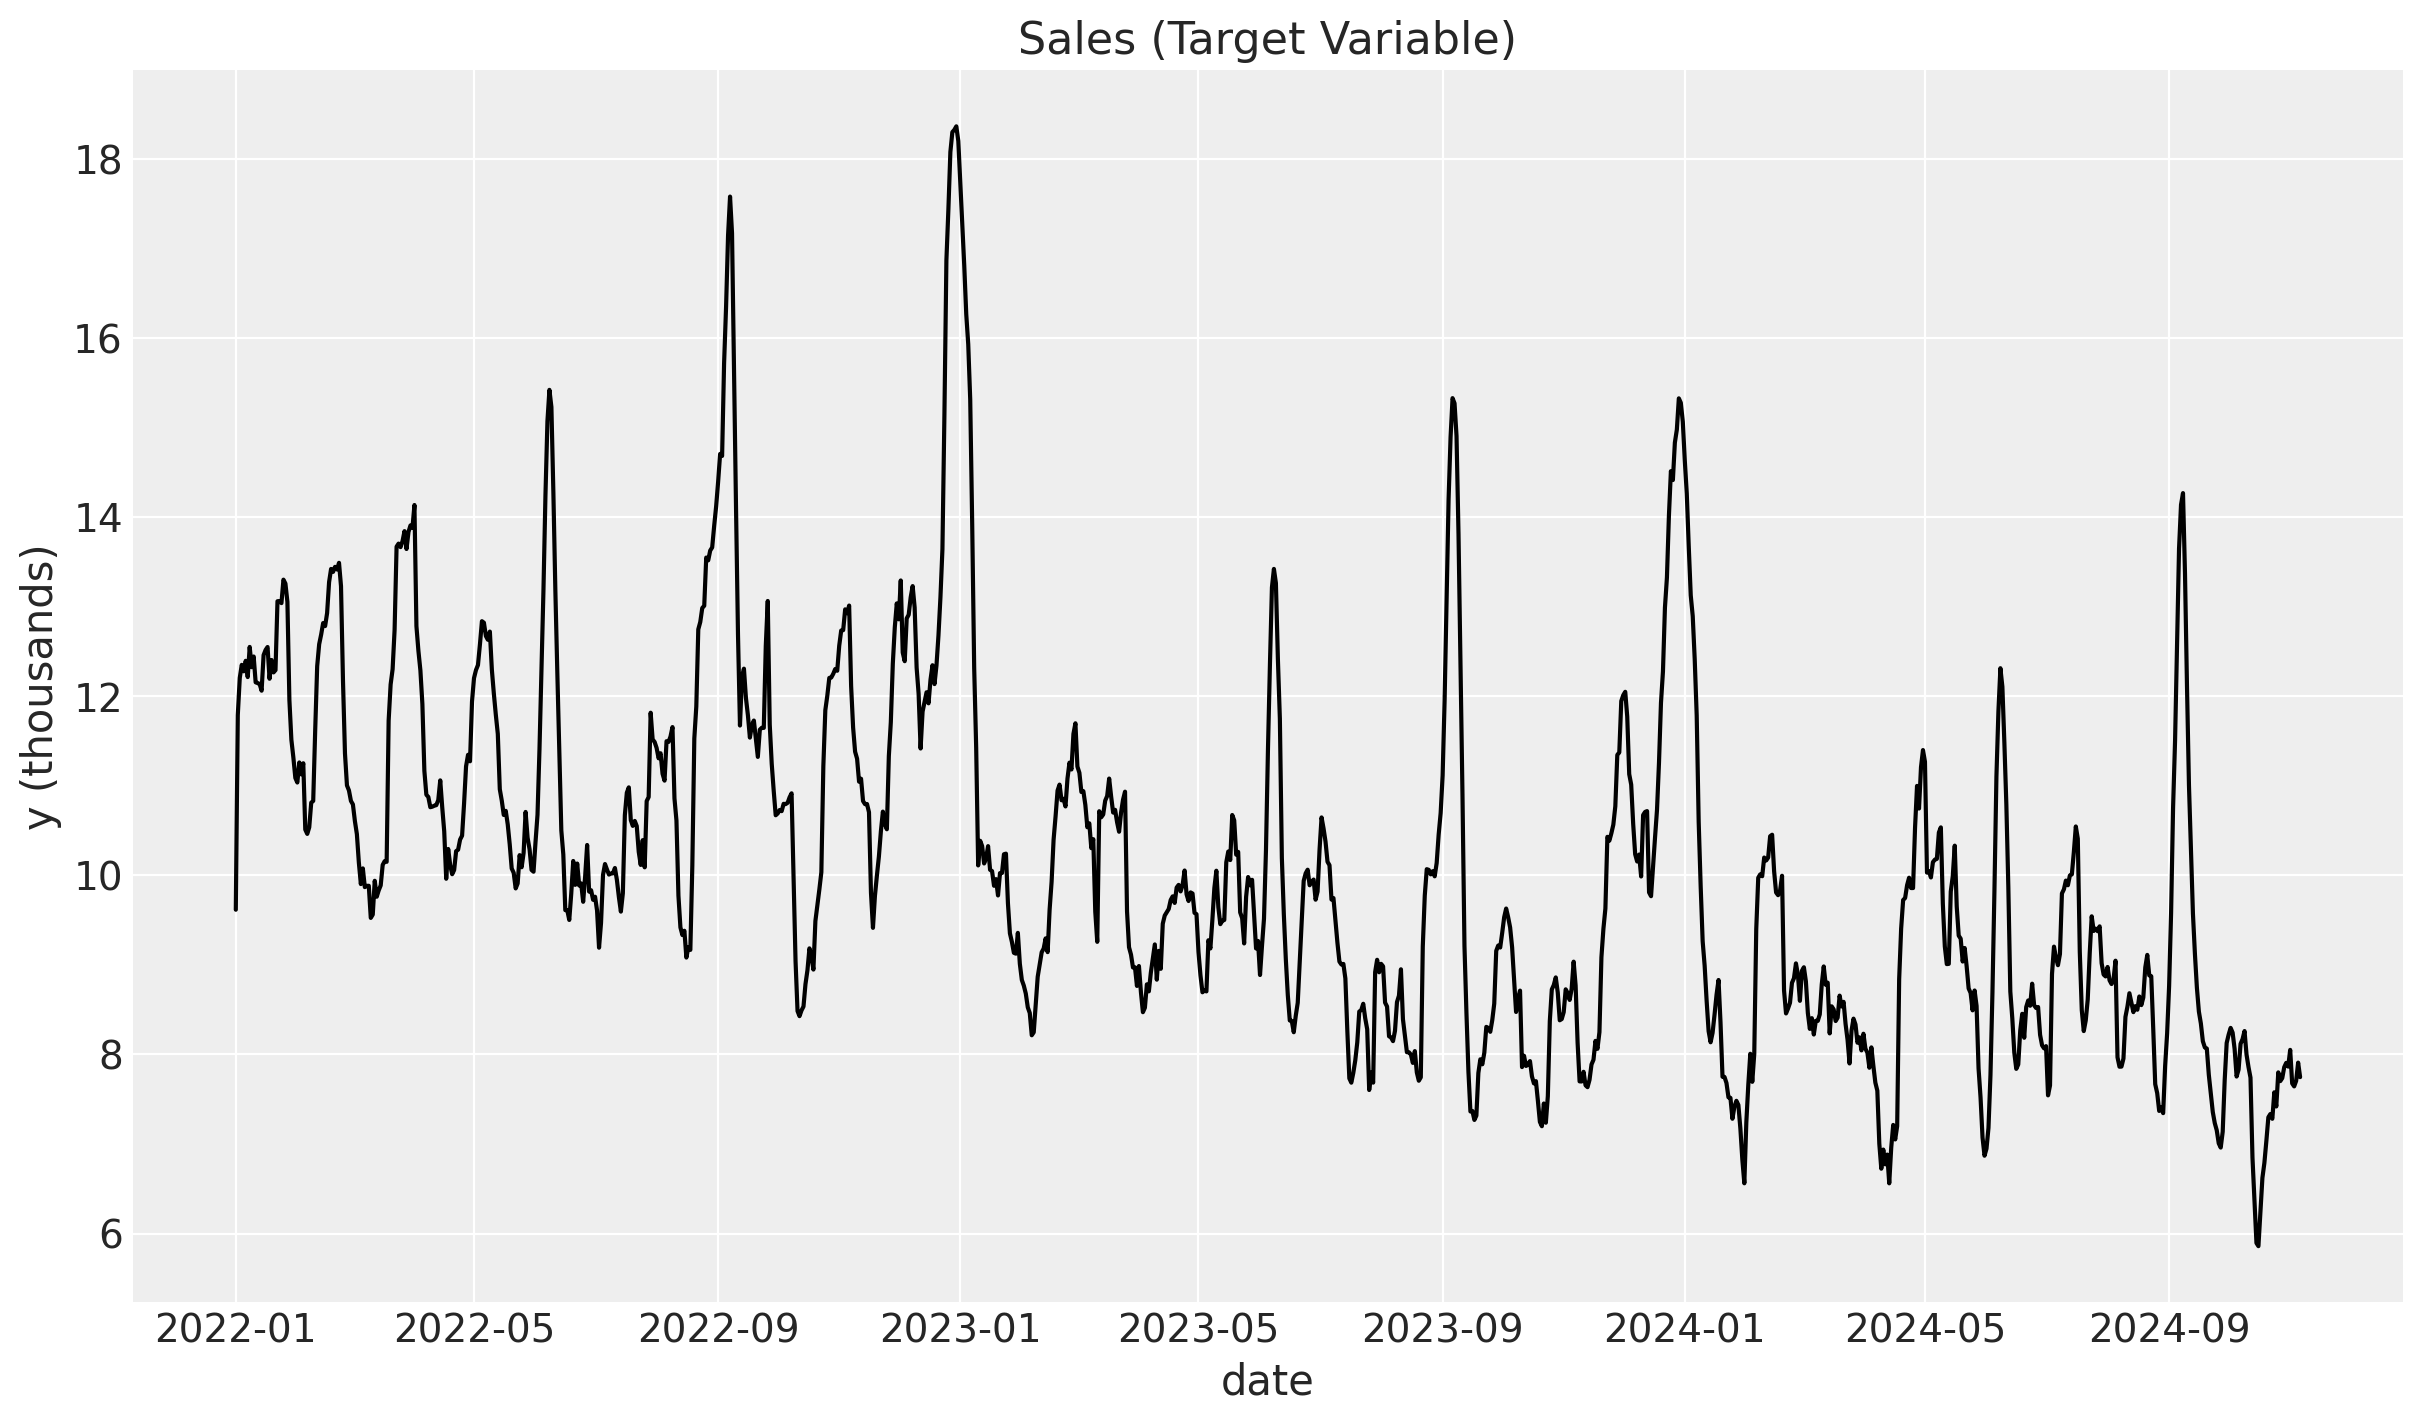

In [ ]:
df["intercept"] = 1.5
df["epsilon"] = rng.normal(loc=0.0, scale=0.08, size=n)

df["y"] = (
    df["intercept"]
    + df["holiday_contributions"]
    + df["x2_adstock_saturated"]
    + df["x3_adstock_saturated"]
    + df["epsilon"]  # Noise
) - df["inflation"]

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

We can scale the full dataset and we'll have finally something very similar to reality.

In [ ]:
# scale df by abs max per column
df["date"] = pd.to_datetime(df["date_week"])
scaled_df = df.copy()
for col in scaled_df.columns:
    if col != 'date' and col != 'date_week':
        scaled_df[col] = scaled_df[col] / scaled_df[col].abs().max()

scaled_df[["date", "x1", "x2", "x3", "y"]].head()

date        x1        x2        x3         y
0 2022-01-01  0.311103  0.416608  0.709209  0.523628
1 2022-01-02  0.346200  0.417910  0.718519  0.641921
2 2022-01-03  0.310798  0.404066  0.690251  0.664626
3 2022-01-04  0.301643  0.395861  0.693495  0.672532
4 2022-01-05  0.248688  0.379114  0.679055  0.668596

# Intial approach

If we have a dataset like the one we just created, we can try to fit a model with the following to find the causal impact of each channel on the target variable. For the example, we'll use a simple model from Pymc-Marketing for this purpose.

Let's see what happens if we fit a model with all what we have without any knowledge of the causal structure.

In [ ]:
scaled_df[["date", "x1", "x2", "x3", "y"]].head()

date        x1        x2        x3         y
0 2022-01-01  0.311103  0.416608  0.709209  0.523628
1 2022-01-02  0.346200  0.417910  0.718519  0.641921
2 2022-01-03  0.310798  0.404066  0.690251  0.664626
3 2022-01-04  0.301643  0.395861  0.693495  0.672532
4 2022-01-05  0.248688  0.379114  0.679055  0.668596

In [ ]:
model_config = {
    "intercept": Prior("Gamma", mu=1, sigma=1),
    "likelihood": Prior("Normal", sigma=Prior("Normal", mu=0, sigma=.5)),
}

fit_kwargs = dict(nuts_sampler="numpyro", random_seed=rng,)

In [ ]:
X = df.drop(columns=["y"])
y = df["y"]

In [ ]:
mmm = MMM(
    date_column="date",
    channel_columns=[
        "x1",
        "x2",
        "x3"
    ],
    control_columns=[
        "holiday_signal",
        "inflation"
    ],
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
)
mmm.fit(X, y, **fit_kwargs)
mmm.sample_posterior_predictive(
    X=X,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

<xarray.Dataset> Size: 17MB
Dimensions:  (sample: 2000, date: 1041)
Coordinates:
  * date     (date) datetime64[ns] 8kB 2022-01-01 2022-01-02 ... 2024-11-06
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 17MB 9.457 9.736 9.486 ... 7.697 7.59 7.888
Attributes:
    created_at:                 2025-03-07T11:37:27.082031+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

Observing the summary from the sampling process for the main variables of the model, we can see that sampling process was stable and converged well. All rhat ( Gelman-Rubin statistic) are close to 1 and the effective sample size is high for bulk and tail.

We have enough variance on the estimates, and the mcse (Monte Carlo Standard Error) is low on majority of the variables.

In [ ]:
#summary of model idata
az.summary(mmm.idata, var_names=["saturation_alpha", "saturation_lam", "adstock_alpha", "gamma_control"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
saturation_alpha[x1]           0.049  0.025   0.008    0.093      0.001   
saturation_alpha[x2]           0.952  0.146   0.743    1.228      0.007   
saturation_alpha[x3]           0.934  0.160   0.664    1.236      0.005   
saturation_lam[x1]             2.250  0.659   1.140    3.579      0.016   
saturation_lam[x2]             0.123  0.033   0.064    0.185      0.001   
saturation_lam[x3]             1.990  0.671   0.711    3.180      0.020   
adstock_alpha[x1]              0.461  0.256   0.014    0.792      0.009   
adstock_alpha[x2]              0.363  0.040   0.291    0.436      0.001   
adstock_alpha[x3]              0.437  0.071   0.298    0.568      0.002   
gamma_control[holiday_signal]  0.189  0.003   0.184    0.195      0.000   
gamma_control[inflation]      -0.054  0.001  -0.055   -0.053      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
saturation_alpha[x1]             0.001    1118.0    1089.0   1.00  
saturation_alpha[x2]             0.005     527.0     636.0   1.01  
saturation_alpha[x3]             0.004    1023.0    1193.0   1.00  
saturation_lam[x1]               0.012    1499.0    1010.0   1.00  
saturation_lam[x2]               0.001     522.0     602.0   1.00  
saturation_lam[x3]               0.014    1126.0    1077.0   1.00  
adstock_alpha[x1]                0.007     874.0    1137.0   1.00  
adstock_alpha[x2]                0.001    1125.0    1410.0   1.00  
adstock_alpha[x3]                0.002     866.0     899.0   1.00  
gamma_control[holiday_signal]    0.000    1550.0    1165.0   1.00  
gamma_control[inflation]         0.000    1986.0    1332.0   1.00

How the recover contributions look like, If we compare to the real contributions?


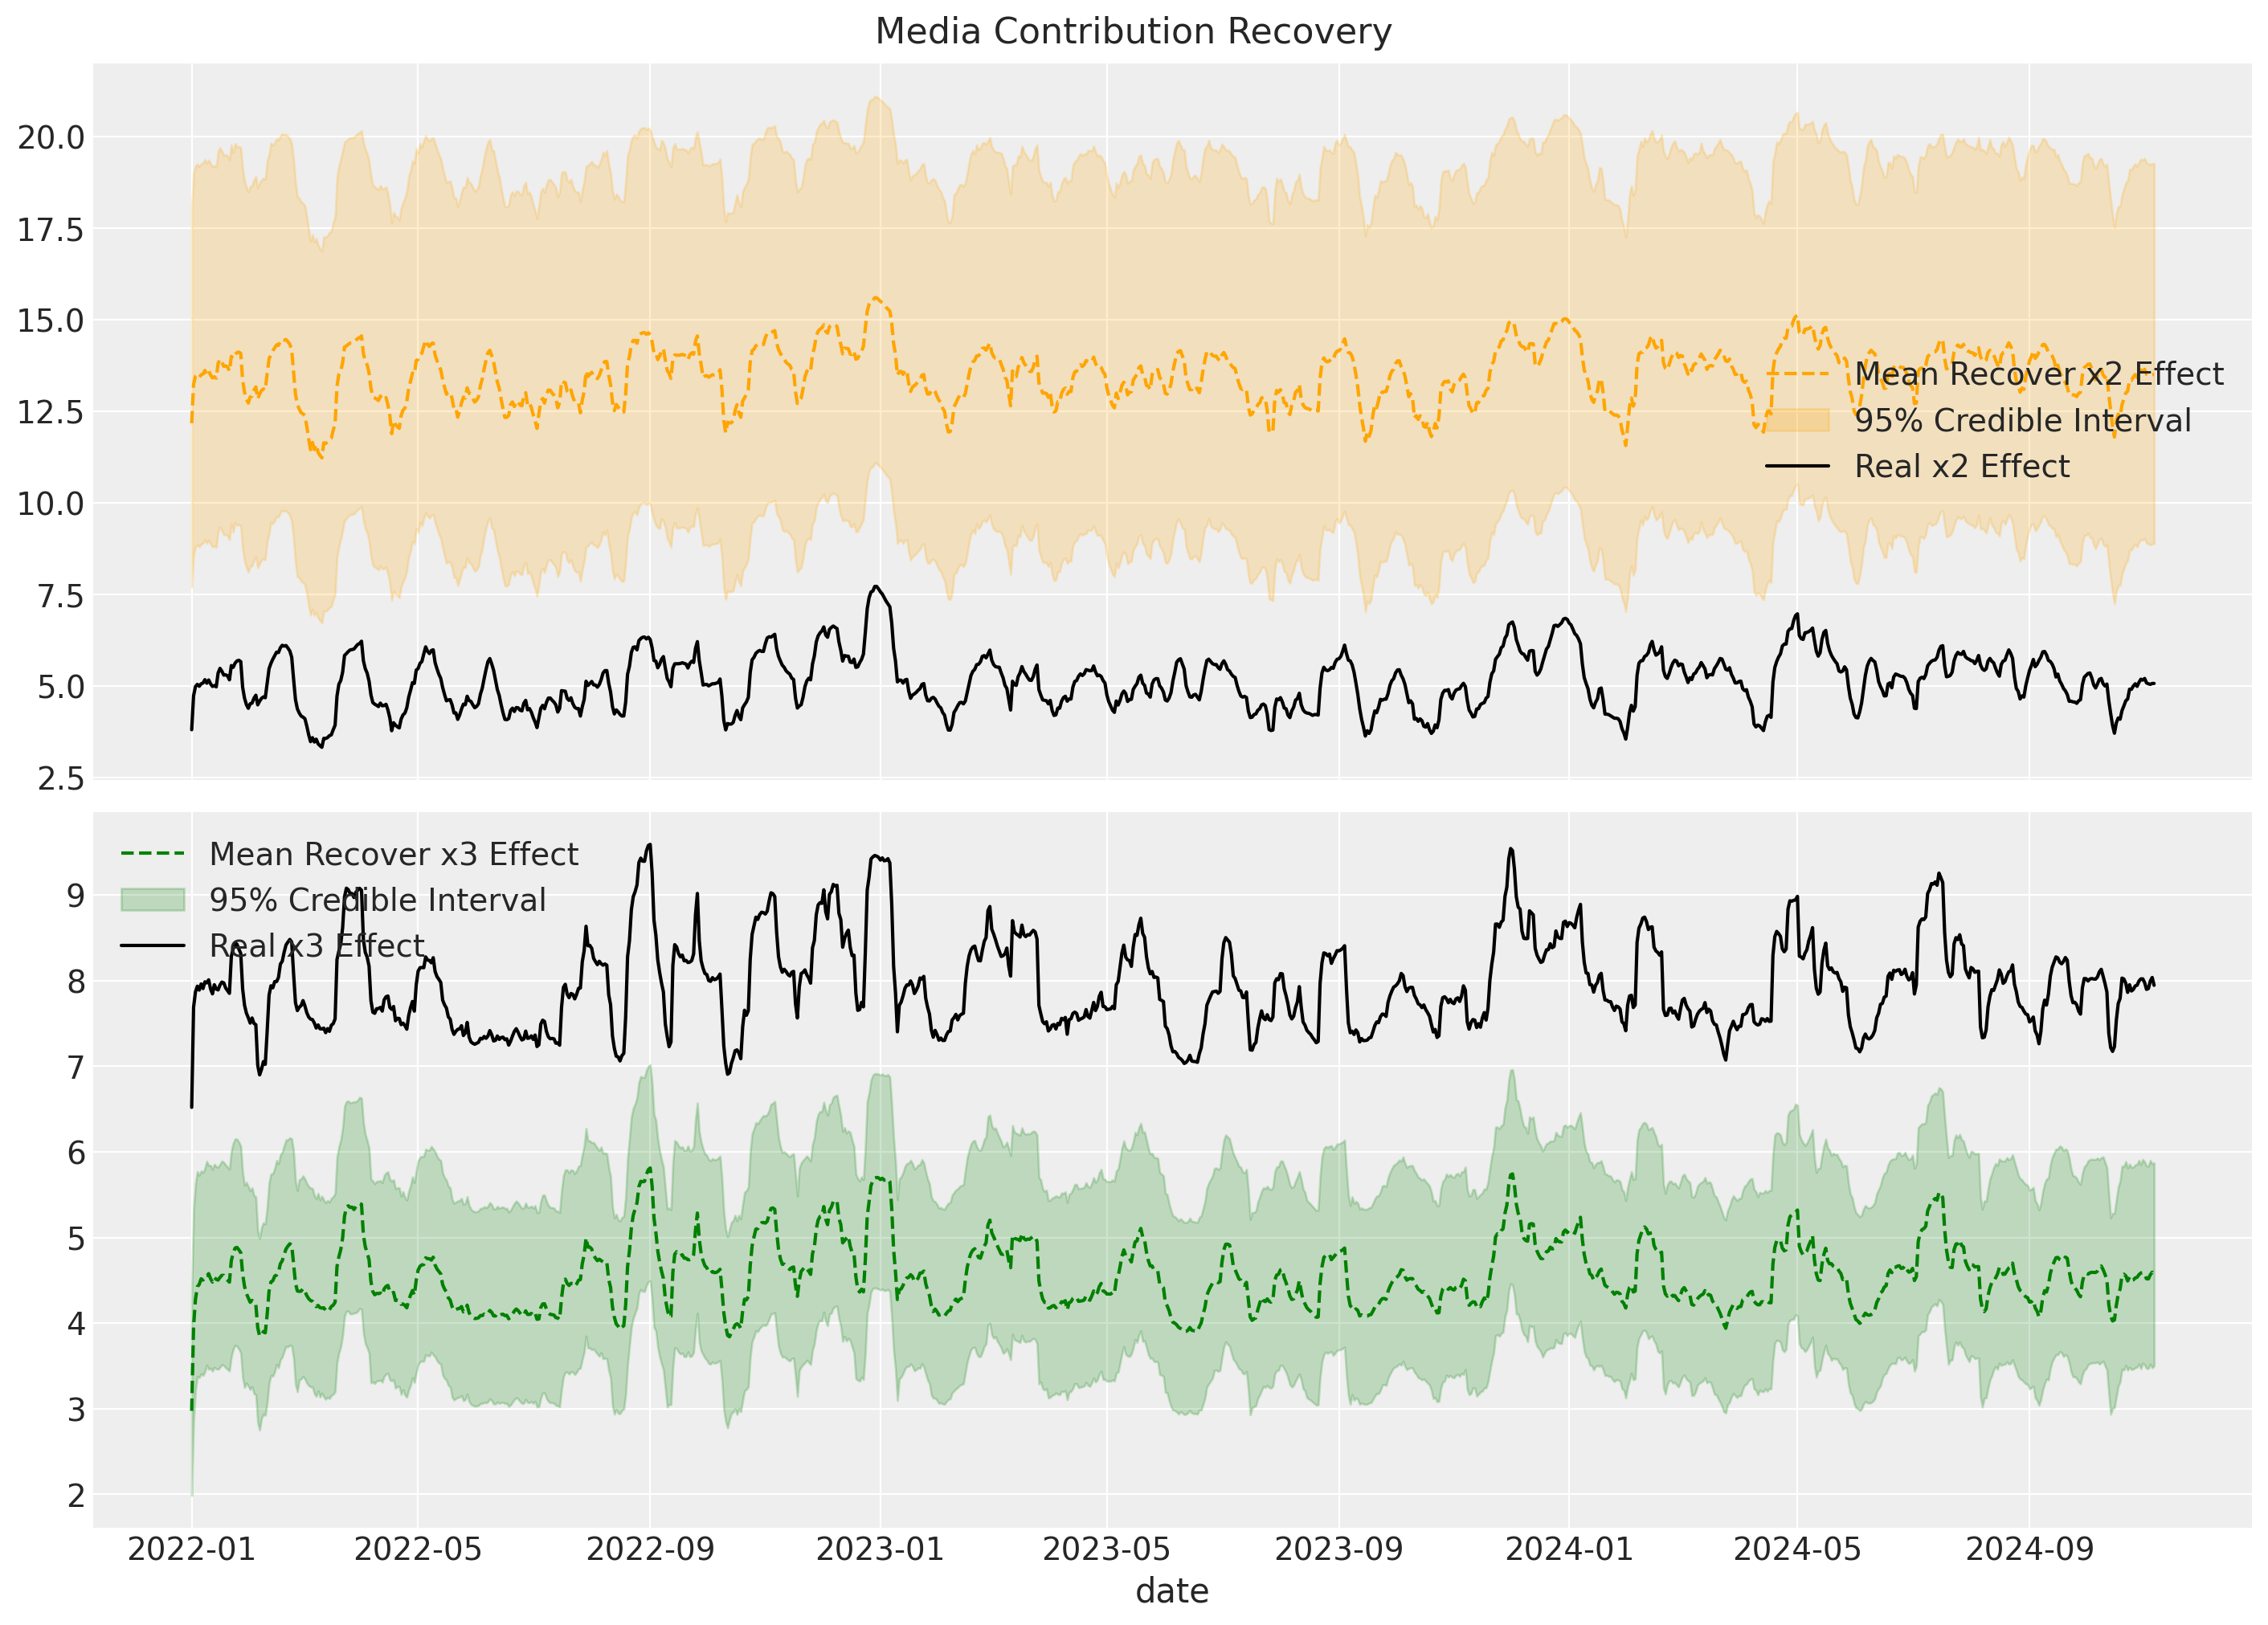

In [ ]:
initial_model_recover_effect = (
    az.hdi(mmm.fit_result["channel_contribution"], hdi_prob=0.95)
    * mmm.target_transformer["scaler"].scale_.item()
)
initial_model_mean_effect = (
    mmm.fit_result.channel_contribution.mean(dim=["chain", "draw"])
    * mmm.target_transformer["scaler"].scale_.item()
)

fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
# x2 -> online
ax[0].plot(
    date_range,
    initial_model_mean_effect.sel(channel="x2"),
    label="Mean Recover x2 Effect",
    linestyle="--",
    color="orange",
)
ax[0].fill_between(
    date_range,
    initial_model_recover_effect.channel_contribution.isel(hdi=0).sel(channel="x2"),
    initial_model_recover_effect.channel_contribution.isel(hdi=1).sel(channel="x2"),
    alpha=0.2,
    label="95% Credible Interval",
    color="orange",
)
ax[0].plot(
    date_range, df["x2_adstock_saturated"], label="Real x2 Effect", color="black"
)

# x3 -> internal
ax[1].plot(
    date_range,
    initial_model_mean_effect.sel(channel="x3"),
    label="Mean Recover x3 Effect",
    linestyle="--",
    color="green",
)
ax[1].fill_between(
    date_range,
    initial_model_recover_effect.channel_contribution.isel(hdi=0).sel(channel="x3"),
    initial_model_recover_effect.channel_contribution.isel(hdi=1).sel(channel="x3"),
    alpha=0.2,
    label="95% Credible Interval",
    color="green",
)
ax[1].plot(
    date_range, df["x3_adstock_saturated"], label="Real x3 Effect", color="black"
)

# formatting
ax[0].legend()
ax[1].legend()

plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

As anticipated, the model fails to accurately reflect the true contributions, resulting in estimates that significantly deviate from the actual values. How can this occur, and why is this happening?

The explanation is straightforward: by neglecting any causal structure, we inadvertently impose one onto the data. The issue lies in our assumption of the simplest causal framework, which rarely aligns with real-world complexity.

What kind of causal structure are we implicitly assuming when we fit the model?

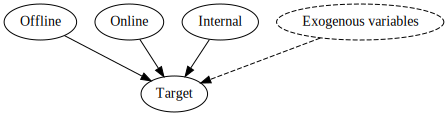

In [ ]:
# Initialize a directed graph
naive_causal_mmm_graph = Digraph()

# Add nodes
naive_causal_mmm_graph.node("X1", "Offline")
naive_causal_mmm_graph.node("X2", "Online")
naive_causal_mmm_graph.node("X3", "Internal")
naive_causal_mmm_graph.node("E", "Exogenous variables", style="dashed")
naive_causal_mmm_graph.node("T", "Target")

naive_causal_mmm_graph.edge("E", "T", style="dashed")
naive_causal_mmm_graph.edge("X1", "T")
naive_causal_mmm_graph.edge("X2", "T")
naive_causal_mmm_graph.edge("X3", "T")

# Render the graph to SVG and display it inline
svg_str = naive_causal_mmm_graph.pipe(format="svg")
display(SVG(svg_str))

The DAG above represents the causal structure that we are implicitly assuming when we fit the model. Here all variables are independent of each other, and those impact directly the target variable.

During the model development, we established a specific structure and flow for our data. We concluded that the impacts of our channels operate independently of each other. Moreover, we determined that if any component of our ecosystem is missing, its influence will be accounted for by the baseline term due to this equation. As you can see, even by adopting this basic model, we are making significant assumptions.

On one hand, you are assuming that the impact is not linear by applying these transformations, and you are suggesting that the impact is positive and that there may be a maximum delay of a certain number of days.

You've even defined the direction of your relationships. By defining these relationships and assuming no direct causal connections between our variables, we can conclude that, if the nature of their relationship is accurately represented by the provided equation, then by controlling the relevant channels, we could uncover their true effects.

This leads us to which causal DAG we assume is correct, based on our previous assumptions. If you recognize this process, congratulations! You've created a generative model or Structural Causal Model, with a Structural Causal Equation, using PyMC-marketing.

However, this Causal DAG does not depict the true Causal DAG. Since our PyMC model is structural and causal, we must ask: *What happens if I create a model with a different causal structure than the real one?*

The answer is what we observed above, the model will not be able to recover the true causal structure.

# Learning about generative models
Generative models are frameworks that describe how data could be produced in the real world. They outline a process by defining probability distributions for each component, simulating the creation of data from underlying random variables. This approach captures uncertainty and variability, providing a complete picture of the data generation mechanism.

In PyMC, this concept is at the core of every model. PyMC lets you explicitly define priors, likelihoods, and the structure of your data generation process. Even simple models built in PyMC carry an inherent generative assumption, making them flexible and robust in representing how data might naturally arise.

This means that each possible graph with N number of variables can be a specific model. How many models could we specify if we have 5 variables for one target?

In [ ]:
import math
from functools import lru_cache

@lru_cache(maxsize=None)
def dag_with_exactly_s_sources(n: int, s: int) -> int:
    """
    Count DAGs with exactly s source nodes.

    Uses formula: S(n,s) = C(n,s) * sum[(-1)^j * C(n-s,j) * 2^((m-j)(m-j-1)/2) *
    (2^(m-j)-1)^s] where m=n-s and j=0..m. When n=s, S(n,n)=1.

    Parameters
    ----------
    n : int
        Total number of labeled nodes
    s : int
        Number of source nodes

    Returns
    -------
    int
        Number of possible DAGs
    """
    if n == s:
        return 1
    total = 0
    m = n - s
    for j in range(m + 1):
        term = (
            (-1) ** j
            * math.comb(m, j)
            * 2 ** (((m - j) * (m - j - 1)) // 2)
            * (2 ** (m - j) - 1) ** s
        )
        total += term
    return math.comb(n, s) * total

def count_valid_final_graphs_with_parents(num_regressors: int, num_parents: int) -> int:
    """Count valid final graphs with parent node restrictions.

    The counting process has two main steps:

    1. Build a DAG among regressors where parents have no incoming edges:
       - For non-parents (Q = num_regressors - num_parents), count DAGs with given sinks
       - Parents can only have edges to non-parents (Q options each)
       - Non-sink parents must have ≥1 outgoing edge (2^Q - 1 ways)
       - Sink parents have no edges (1 way)

    2. Add edges from regressors to target:
       - Sink regressors must connect to target
       - Non-sink regressors optionally connect
       - Yields factor 2^(num_regressors - total_sinks)

    The total count formula is:
    sum_{s_p=0}^P sum_{s_q=1}^Q [binom(P,s_p) * (2^Q-1)^(P-s_p) *
    (DAGs_Q_s_q) * 2^((P+Q)-(s_p+s_q))]

    where P = num_parents, Q = num_regressors - num_parents

    When Q = 0 (all regressors are parents), the final graph is unique.

    Parameters
    ----------
    num_regressors : int
        Total number of regressor nodes in the graph
    num_parents : int
        Number of designated parent nodes that cannot have incoming edges

    Returns
    -------
    int
        Total count of valid final graph configurations
    """
    P = num_parents
    Q = num_regressors - num_parents  # non-parents
    if Q < 0:
        raise ValueError("num_parents cannot exceed num_regressors")

    # Case where all regressors are parents: no DAG edges are allowed;
    # every node is isolated (and hence a sink),
    # so the regressor-to-target assignment is forced.
    if Q == 0:
        return 1

    total = 0
    # s_p: number of parents that end up as sinks
    # (i.e. with no outgoing edge to any non-parent)
    for s_p in range(P + 1):
        # For each parent:
        #   - If not a sink: choose at least one outgoing edge
        #     among Q non-parents: (2^Q - 1) ways.
        #   - If a sink: only 1 way (choose no outgoing edge).
        parent_config = math.comb(P, s_p) * ((2**Q - 1) ** (P - s_p))
        # s_q: number of sinks among non-parents in the DAG on Q nodes.
        # Note: Every DAG on at least one node has at least one sink.
        for s_q in range(1, Q + 1):
            nonparent_count = dag_with_exactly_s_sources(Q, s_q)
            # Total sinks in the regressor
            # DAG is s_p (from parents) plus s_q (from non-parents)
            total_sinks = s_p + s_q
            # For each regressor that is not a sink,
            # the regressor-to-target edge is optional.
            # Thus, a factor of 2^( (P+Q) - total_sinks ).
            assignment_factor = 2 ** ((P + Q) - total_sinks)
            total += parent_config * nonparent_count * assignment_factor
    return total

In [ ]:
possible_dags = count_valid_final_graphs_with_parents(num_regressors=5, num_parents=2)
print(f"Number of possible DAGs with two parents (Graphical/Generative Model): {possible_dags:,}")

Number of possible DAGs with two parents (Graphical/Generative Model): 12,375


In [ ]:
possible_dags = count_valid_final_graphs_with_parents(num_regressors=5, num_parents=1)
print(f"Number of possible DAGs with one parent (Graphical/Generative Model): {possible_dags:,}")

Number of possible DAGs with one parent (Graphical/Generative Model): 52,855


The number of possible models we can generate with two out of five variables as parents is around 12,000, while having just one parent increases that number to approximately 52,000. Interestingly, removing a single parent node triples the potential models we can create, effectively multiplying the number of possible scenarios.

This sheds light on the challenges posed by large models:  
a) As the number of variables increases, the exponential growth in potential relationships becomes overwhelming, making it difficult to pinpoint our actual situation.  
b) With more variables, the likelihood of mistakenly controlling for the wrong variables also increases.

This latter point aligns with our earlier observation: if we control for inappropriate variables, the model fails to recover the true causal structure.

So, why is it problematic to control for certain variables? Every variable should add more explanatory power, no?. Let's start learning about structures to understand.

# Learning about causal structures

**Forks**: A fork is a causal structure where a single variable acts as a common cause for two or more other variables. This common cause transmits its influence to all its direct descendants. The existence of a fork creates confounding, making the relationship between the descendant variables appear related. Controlling for the common cause can effectively block the backdoor paths created by this structure.

**Chains**: A chain represents a sequential causal pathway where one variable influences another, which in turn affects a third variable. This structure highlights the mediation process through which causal effects are transmitted. The intermediate variable acts as a mediator, carrying the influence from the initial cause to the final outcome. Analyzing chains helps distinguish between direct and indirect effects in a causal system. Controlling for the mediator inappropriately may block parts of the causal effect that are of interest.

**Colliders**: A collider is a variable that is the common effect of two or more causal factors. It sits at the convergence of different causal paths and can introduce spurious associations when conditioned upon. Controlling for a collider can inadvertently open up non-causal, backdoor paths, leading to biased estimates. This phenomenon, known as collider bias, distorts the true relationships among the causal variables. Avoiding conditioning on colliders is crucial for maintaining the validity of causal models.

<ipython-input-25-5cec017296d5>:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


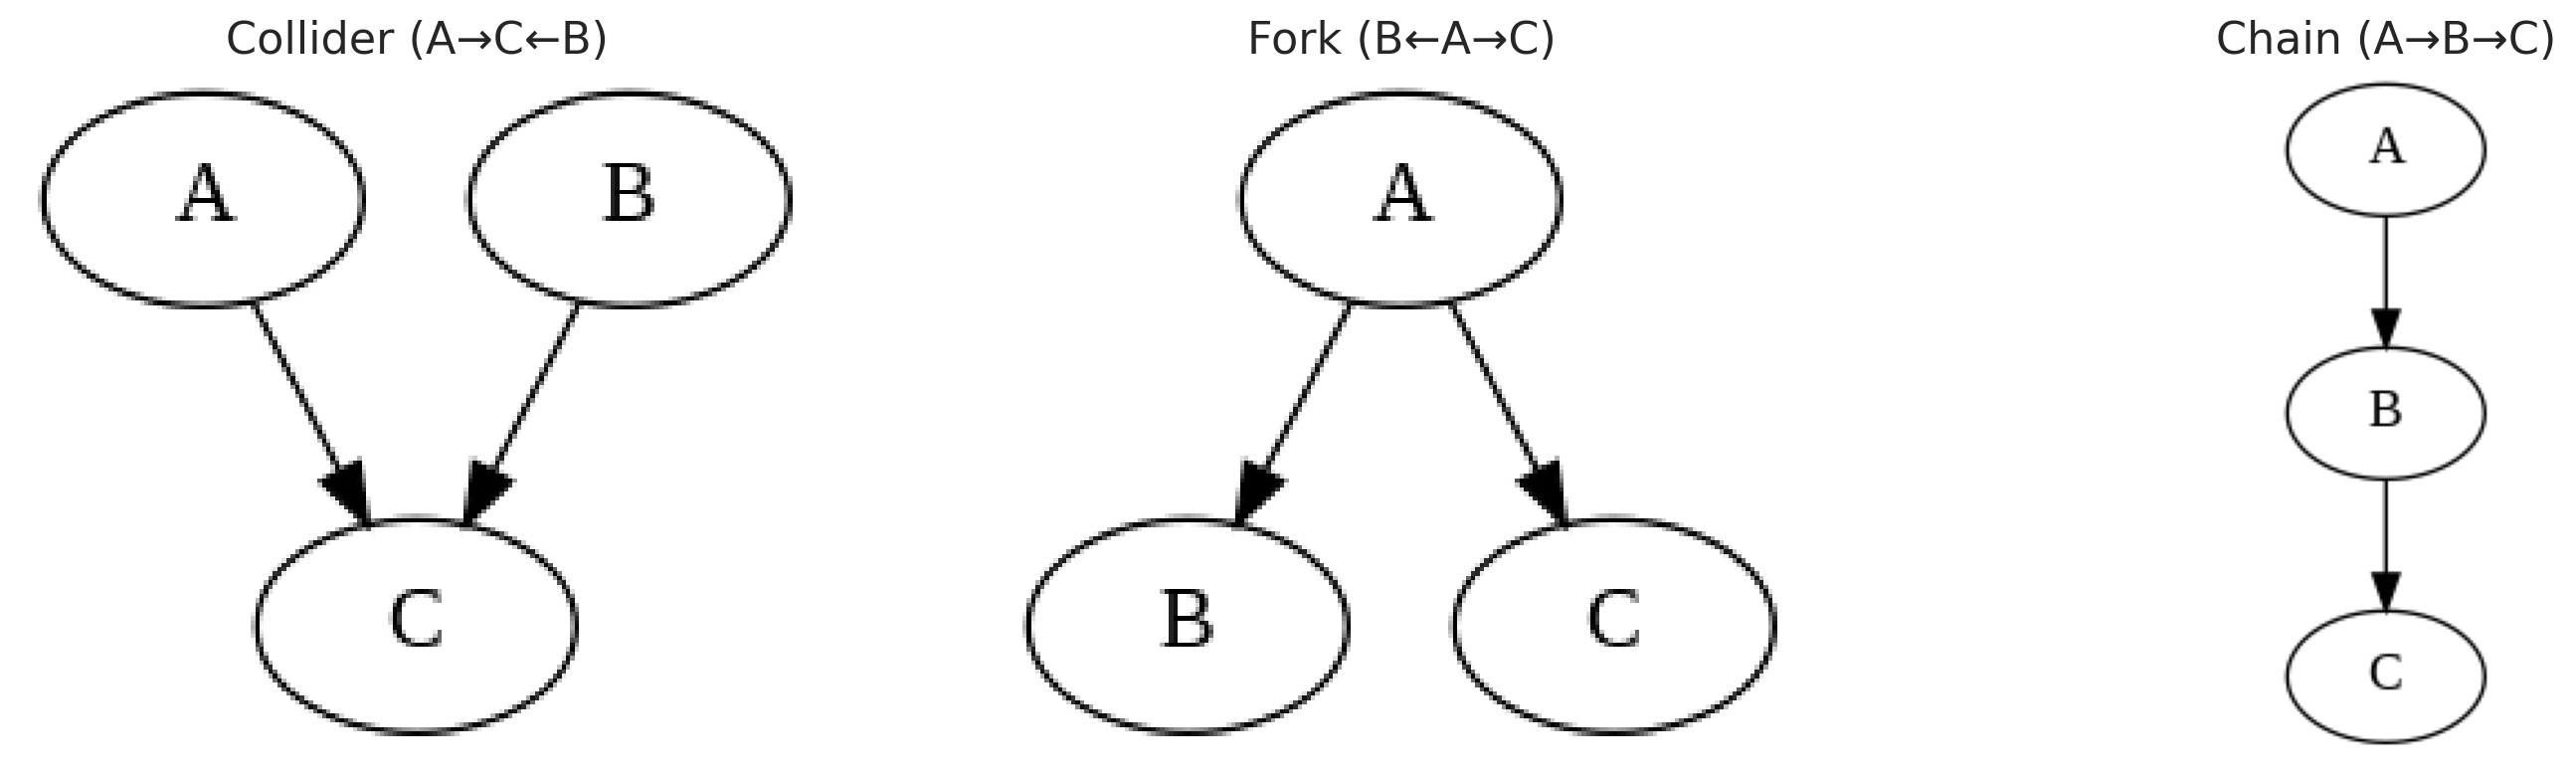

In [ ]:
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Create collider DAG
collider = Digraph()
collider.attr(rankdir='TB')
collider.node('A', 'A')
collider.node('B', 'B')
collider.node('C', 'C')
collider.edge('A', 'C')
collider.edge('B', 'C')
ax1.set_title('Collider (A→C←B)')
ax1.imshow(Image.open(BytesIO(collider.pipe(format='png'))))
ax1.axis('off')

# Create fork DAG
fork = Digraph()
fork.attr(rankdir='TB')
fork.node('A', 'A')
fork.node('B', 'B')
fork.node('C', 'C')
fork.edge('A', 'B')
fork.edge('A', 'C')
ax2.set_title('Fork (B←A→C)')
ax2.imshow(Image.open(BytesIO(fork.pipe(format='png'))))
ax2.axis('off')

# Create chain DAG
chain = Digraph()
chain.attr(rankdir='TB')
chain.node('A', 'A')
chain.node('B', 'B')
chain.node('C', 'C')
chain.edge('A', 'B')
chain.edge('B', 'C')
ax3.set_title('Chain (A→B→C)')
ax3.imshow(Image.open(BytesIO(chain.pipe(format='png'))))
ax3.axis('off')

plt.tight_layout()
plt.show()

Causal structures play a crucial role in various causal inference methods, serving as the foundation for their functionality. For instance, chain structures are key to methods like instrumental variables (IV). In IV analysis, this chain structure comes into play by introducing an instrument—a variable that impacts the exposure but does not directly affect the outcome, except through that exposure. This approach helps break the confounding path, allowing us to isolate the exogenous variation in treatment.

As a result, it enables a consistent estimation of causal effects, even when we encounter endogeneity. Therefore, grasping chain structures is essential, as it not only supports the rationale behind IV methods but also underscores the significance of identifying valid instruments.

If you're particularly interested in learning more about IVs, I recommend checking out a post by Anton Bugaev or heading to the fifth floor if you’re at Bolt.

Ultimately, each of these causal structures exhibits different observational behaviors. This means that based on the observational data, we can deduce which structure is present, and consecuently determinate whats the right variable set to control.

One thing to understand what to control is find out the parent nodes to avoid to control by mediators, we could identify this understanding the conditional dependencies.

# Lets check conditional independencies
Conditional independence is a core concept in probability theory and statistics where two variables are independent of each other once a third variable is held constant. This means that, given the value of the conditioning variable, the two variables do not provide additional information about one another. In causal discovery, conditional independencies are crucial because they reveal the underlying structure of causal relationships in a model or a directed acyclic graph (DAG). By identifying these independencies, we can determine how variables are related to each other, or not.

Bayesian regression models allow us to estimate the conditional expectation of an outcome given a set of predictors, effectively uncovering the underlying conditional probabilities. In a bayesian linear regression, for example, we estimate $E(Y \mid X) = \beta_0 + \beta_1X_1 + \ldots + \beta_kX_k$, which represents the average outcome $Y$ when the predictors $X_1, \dots, X_k$ are held at specific values.

In [ ]:
def build_and_sample_model(data: pd.DataFrame, formula: str):
    """
    Build and sample a linear model from a formula.
    """
    # Parse the formula to get target and channels
    target, channels = formula.split('~')
    target = target.strip()
    channels = [ch.strip() for ch in channels.split('+') if ch.strip() != "1"]

    # Define coordinates
    coordinates = {"date": data.date.unique()}
    if channels:  # If there are regressors, include them in coordinates
        coordinates["channel"] = channels

    # Filter the dataset based on the formula
    with pm.Model(coords=coordinates) as linear_model:
        # Load Data in Model
        target_data = pm.Data("target", data[target].values, dims="date")

        # Constant or intercept
        intercept = pm.Gamma("intercept", mu=3, sigma=2)

        mu_var = 0

        if channels:  # If there are regressors, include them
            regressors = pm.Data("regressors", data[channels].values, dims=("date", "channel"))
            gamma = pm.Normal("gamma", mu=3, sigma=2, dims="channel")
            mu_var += (regressors * gamma).sum(axis=-1) + intercept
        else:
            mu_var += intercept

        # Likelihood
        pm.Normal("likelihood", mu=mu_var, sigma=pm.Gamma("sigma", mu=2, sigma=3), observed=target_data, dims="date")

        # Sample
        idata = pm.sample_prior_predictive(random_seed=42)
        idata.extend(
            pm.sample(tune=1000, draws=500, chains=4, random_seed=42, target_accept=0.9, nuts_sampler="numpyro", progressbar=False)
        )
        pm.compute_log_likelihood(idata, progressbar=False)
        idata.extend(
            pm.sample_posterior_predictive(idata, random_seed=42)
        )

    return (idata, linear_model)


In [ ]:
idata1, model1 = build_and_sample_model(
    scaled_df,
    "x1 ~ 1"
)

idata2, model2 = build_and_sample_model(
    scaled_df,
    "x1 ~ x2 + 1"
)

idata3, model3 = build_and_sample_model(
    scaled_df,
    "x1 ~ x3 + 1"
)

idata4, model4 = build_and_sample_model(
    scaled_df,
    "x1 ~ x2 + x3 + 1"
)

Output()

Output()

Output()

Output()

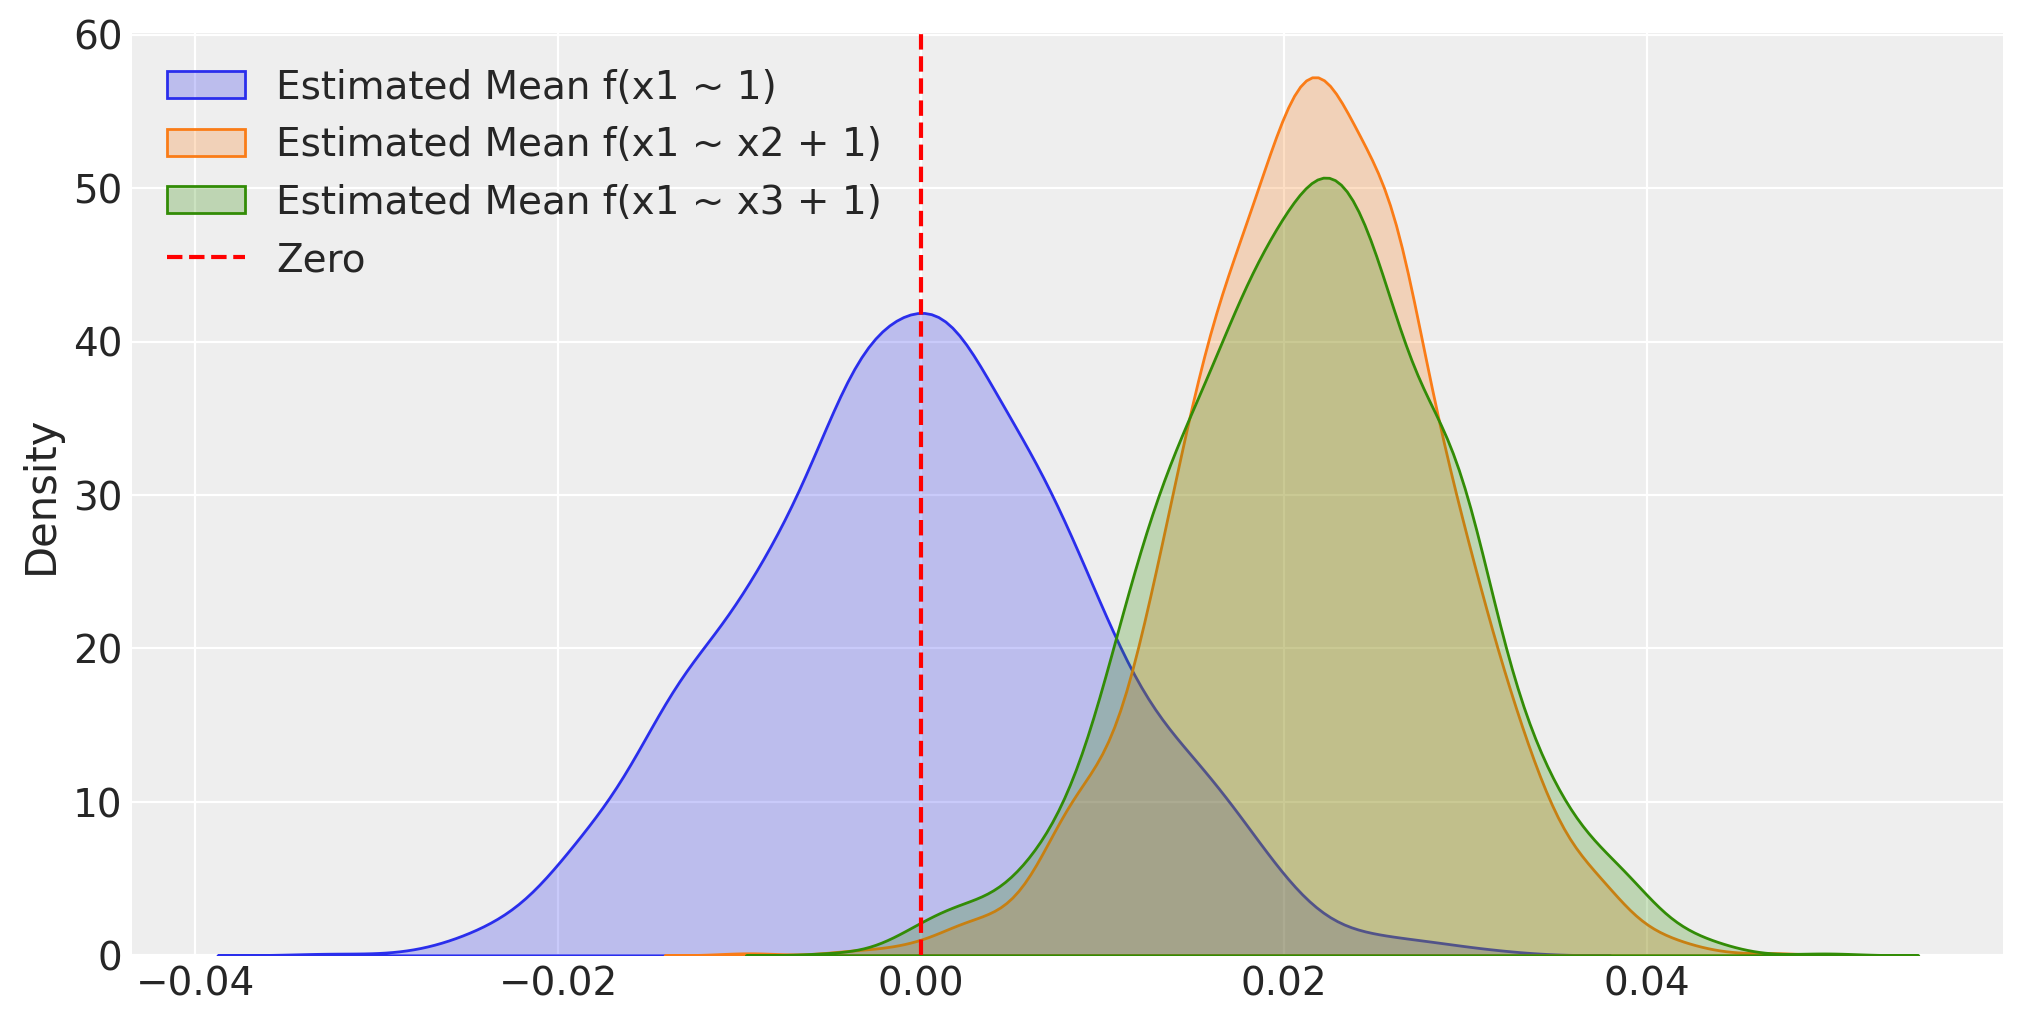

In [ ]:
_real_mean = scaled_df["x1"].mean()
_estimated_mean1 = idata1.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()
_estimated_mean2 = idata2.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()
_estimated_mean3 = idata3.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()

plt.figure(figsize=(10, 5))
sns.kdeplot(_estimated_mean1 - _real_mean, label='Estimated Mean f(x1 ~ 1)', fill=True)
sns.kdeplot(_estimated_mean2 - _real_mean, label='Estimated Mean f(x1 ~ x2 + 1)', fill=True)
sns.kdeplot(_estimated_mean3 - _real_mean, label='Estimated Mean f(x1 ~ x3 + 1)', fill=True)
plt.axvline(0, color='red', linestyle='--', label='Zero')
plt.legend()
plt.show()

In a causal system where the true direction is $x_1$ to $x_2$, the joint distribution factorizes as
$$
P(x_1, x_2) = P(x_1) \, P(x_2 \mid x_1),
$$

where $x_1$ is exogenous and independent of any effects. This structure reflects that $x_1$'s distribution remains unchanged regardless of the downstream variable $x_2$.

When regressing $x_2$ on $x_1$, the model leverages the causal direction, and the conditional distribution $P(x_2 \mid do(x_1))$ is more concentrated than the marginal $P(x_2)$. This results in residuals that are centered around zero, indicating that most variability in $x_2$ is explained by $x_1$.

In contrast, reversing the regression by modeling $x_1$ as a function of $x_2$ disrupts the causal order. The conditional distribution $P(x_1 \mid do(x2))$ deviates from the true marginal $P(x_1)$, as it attempts to capture the cause from its effect, which is not supported by the causal structure.

The bias in the reverse regression arises because conditioning on $x_2$ introduces variability from the noise inherent in $x_2$. This misattribution conflates the independent variability of $x_1$ with that induced by $x_2$, leading to residuals that systematically deviate from zero. Respect to the null model, the residuals are further from zero.

This discrepancy underscores the importance of preserving the correct causal direction to avoid bias, as reversing the regression violates the causal Markov condition.

Using this logic, we can identify not only independent variables but also the candidate parents for each variable based on how they deviate from the null model.

In [ ]:
idata1, model1 = build_and_sample_model(
scaled_df,
"x2 ~ 1"
)

idata2, model2 = build_and_sample_model(
scaled_df,
"x2 ~ x1 + 1"
)

idata3, model3 = build_and_sample_model(
scaled_df,
"x2 ~ x3 + 1"
)

idata4, model4 = build_and_sample_model(
scaled_df,
"x2 ~ x1 + x3 + 1"
)

Output()

Output()

Output()

Output()

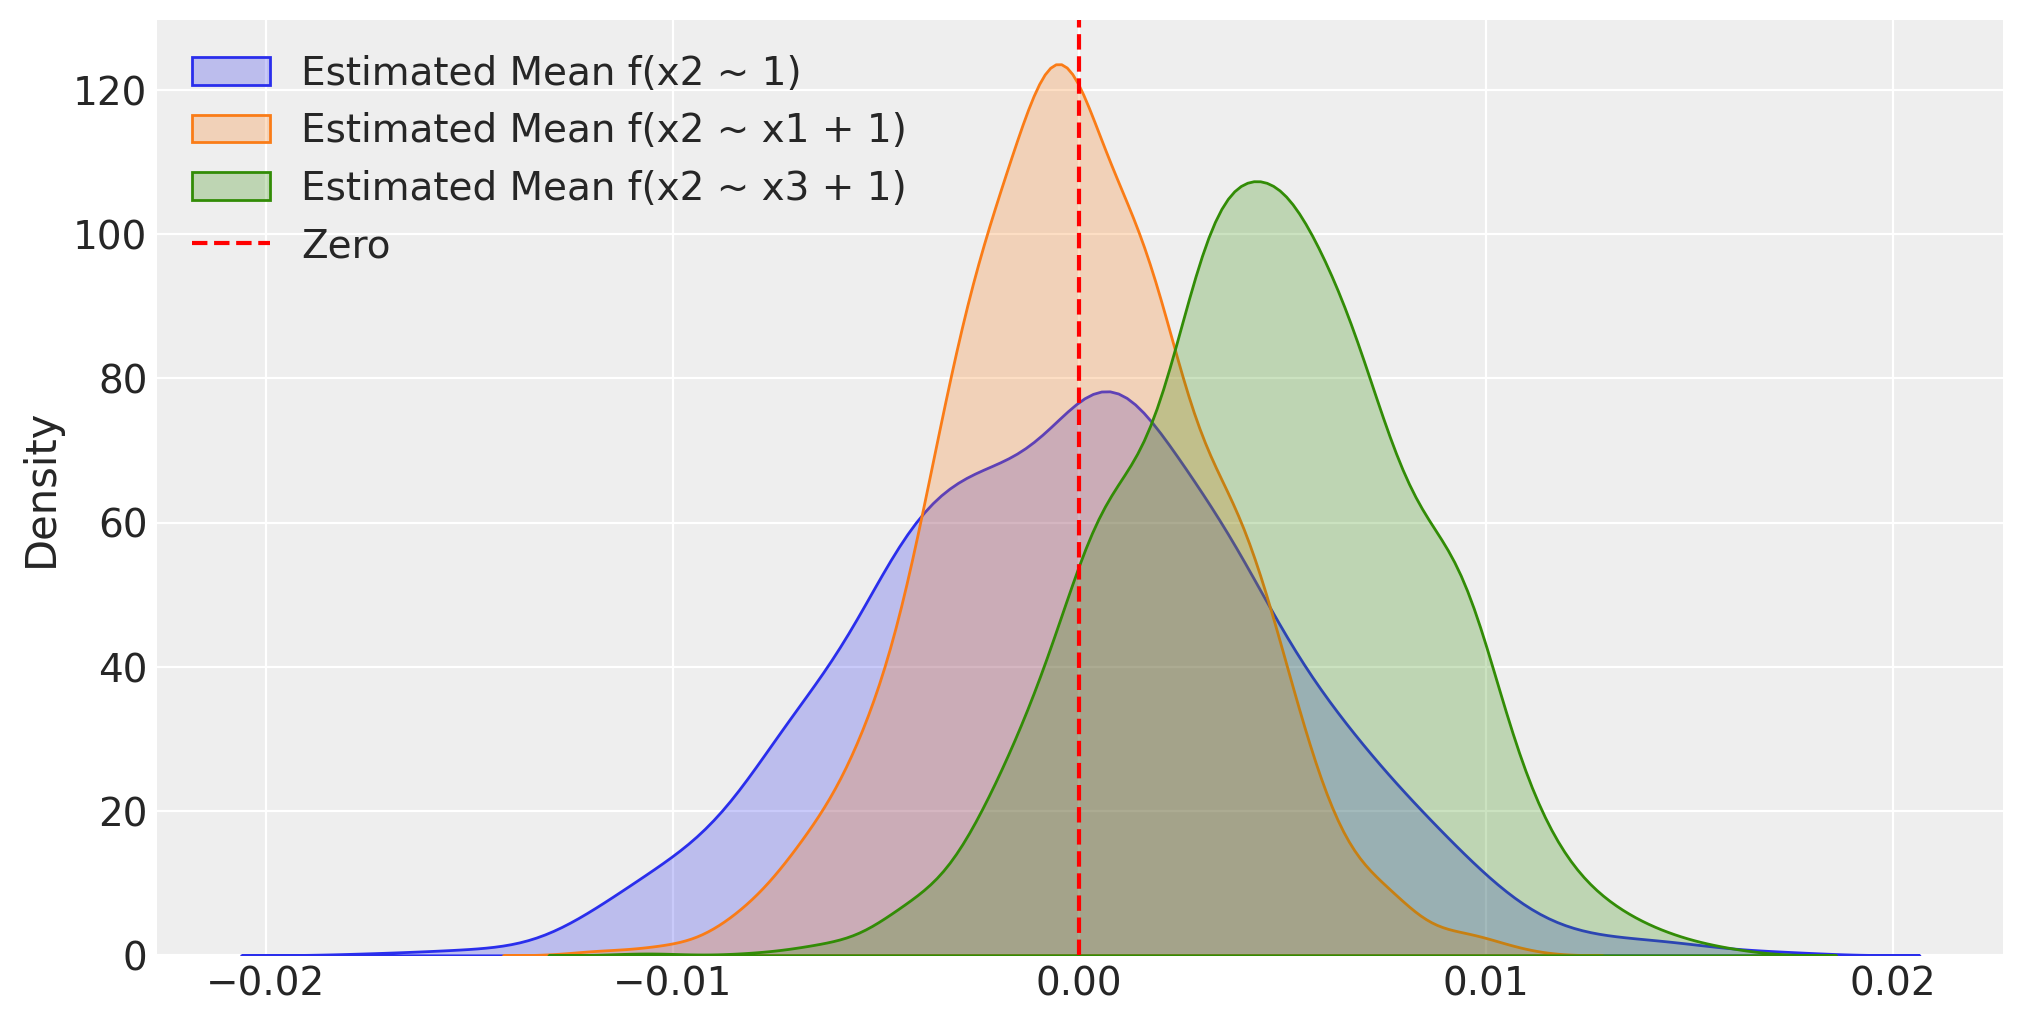

In [ ]:
_real_mean = scaled_df["x2"].mean()
_estimated_mean1 = idata1.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()
_estimated_mean2 = idata2.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()
_estimated_mean3 = idata3.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()

#plot distribution of means and real mean as vertical line
plt.figure(figsize=(10, 5))
sns.kdeplot(_estimated_mean1 - _real_mean, label='Estimated Mean f(x2 ~ 1)', fill=True)
sns.kdeplot(_estimated_mean2 - _real_mean, label='Estimated Mean f(x2 ~ x1 + 1)', fill=True)
sns.kdeplot(_estimated_mean3 - _real_mean, label='Estimated Mean f(x2 ~ x3 + 1)', fill=True)
plt.axvline(0, color='red', linestyle='--', label='Zero')
plt.legend()
plt.show()

Here we can see that the residuals are centered around zero when we regress the marginal probability of $x_2$, but they are closer to zero with a probability distribution narrower than the null model when we regress $x_2$ on $x_1$.

This is a good sign that $x_1$ is a parent of $x_2$.

We can repeat this process for all the variables in our dataset to start to identify the parents of each variable, and thus identifying sections of the true causal graph.

Let's implement this in code.

In [ ]:
class ParentCandidateIdentifier:
    def __init__(self, data: pd.DataFrame, node: str, possible_parents: list, epsilon: float = 0.005):
        """
        Parameters:
            data: DataFrame containing your data.
            node: The target variable for which to identify candidate parents.
            possible_parents: A list of potential parent variable names.
            epsilon: Threshold to define "mass around zero" (default 0.05).
        """
        self.data = data
        self.node = node
        self.possible_parents = possible_parents
        self.epsilon = epsilon
        self.runs = {}
        self.results = None

    def build_and_sample_model(self, formula: str):
        """Wrapper for the sampling function."""
        return build_and_sample_model(self.data, formula)

    def compute_mass_around_zero(self, idata, real_mean):
        """
        Compute the fraction of posterior predictive likelihood samples
        (averaged over dates) within epsilon of the real mean.
        """
        estimated_mean = idata.posterior_predictive.likelihood.mean(dim=["date"]).values.flatten()
        distribution = estimated_mean - real_mean
        mass = np.mean(np.abs(distribution) < self.epsilon)
        return mass, distribution

    def run_all_models(self):
        """
        Run the intercept-only model and each individual parent's model,
        storing the sampling results, mass, and error distributions.
        """
        real_mean = self.data[self.node].mean()
        runs = {}

        # Intercept-only model: P(node)
        formula_intercept = f"{self.node} ~ 1"
        idata_int, _ = self.build_and_sample_model(formula_intercept)
        mass_int, dist_int = self.compute_mass_around_zero(idata_int, real_mean)
        runs["intercept_only"] = {
            "formula": formula_intercept,
            "idata": idata_int,
            "mass": mass_int,
            "distribution": dist_int
        }

        # Individual candidate parent models: P(node|parent)
        for parent in self.possible_parents:
            formula_parent = f"{self.node} ~ {parent} + 1"
            idata_parent, _ = self.build_and_sample_model(formula_parent)
            mass_parent, dist_parent = self.compute_mass_around_zero(idata_parent, real_mean)
            runs[f"parent_{parent}"] = {
                "formula": formula_parent,
                "idata": idata_parent,
                "mass": mass_parent,
                "distribution": dist_parent
            }

        self.runs = runs
        return runs

    def identify_candidate_parents(self):
        """
        Runs all models (if not already run), compares the mass around zero,
        and returns a decision: if the intercept-only model is best, the target
        is independent; otherwise, return the candidate parent with the highest mass.
        """
        if not self.runs:
            self.run_all_models()

        best_key, best_info = max(self.runs.items(), key=lambda x: x[1]["mass"])

        if best_key == "intercept_only":
            decision = "independent"
            candidate_parents = []
        else:
            decision = "dependent"
            candidate_parents = [best_key.split("_", 1)[1]]

        self.results = {
            "results": self.runs,
            "best_model": {best_key: best_info},
            "decision": decision,
            "candidate_parents": candidate_parents
        }
        return self.results

    def plot_distributions(self):
        """
        Plot the error distributions from the stored runs using Seaborn.
        """
        if not self.runs:
            self.run_all_models()

        plt.figure(figsize=(10, 5))
        for key, run in self.runs.items():
            sns.kdeplot(run["distribution"], label=run["formula"], fill=True)
        plt.axvline(0, color='red', linestyle='--', label='Zero Error')
        plt.xlabel("Error (Estimated Mean - Real Mean)")
        plt.ylabel("Density")
        plt.title("Posterior Predictive Error Distributions")
        plt.legend()
        plt.show()

In [ ]:
identifier = ParentCandidateIdentifier(data=scaled_df, node="x3", possible_parents=["x1", "x2"], epsilon=0.0005)
decision_info = identifier.identify_candidate_parents()

Output()

Output()

Output()

In [ ]:
decision_info.keys()

dict_keys(['results', 'best_model', 'decision', 'candidate_parents'])

In [ ]:
decision_info["best_model"]

{'parent_x1': {'formula': 'x3 ~ x1 + 1',
  'idata': Inference data with groups:
  	> posterior
  	> posterior_predictive
  	> log_likelihood
  	> sample_stats
  	> prior
  	> prior_predictive
  	> observed_data
  	> constant_data,
  'mass': 0.3295,
  'distribution': array([-0.00053567,  0.00067946,  0.00032199, ..., -0.00053127,
          0.00152853, -0.0003273 ])}}

In [ ]:
decision_info["candidate_parents"]

['x1']

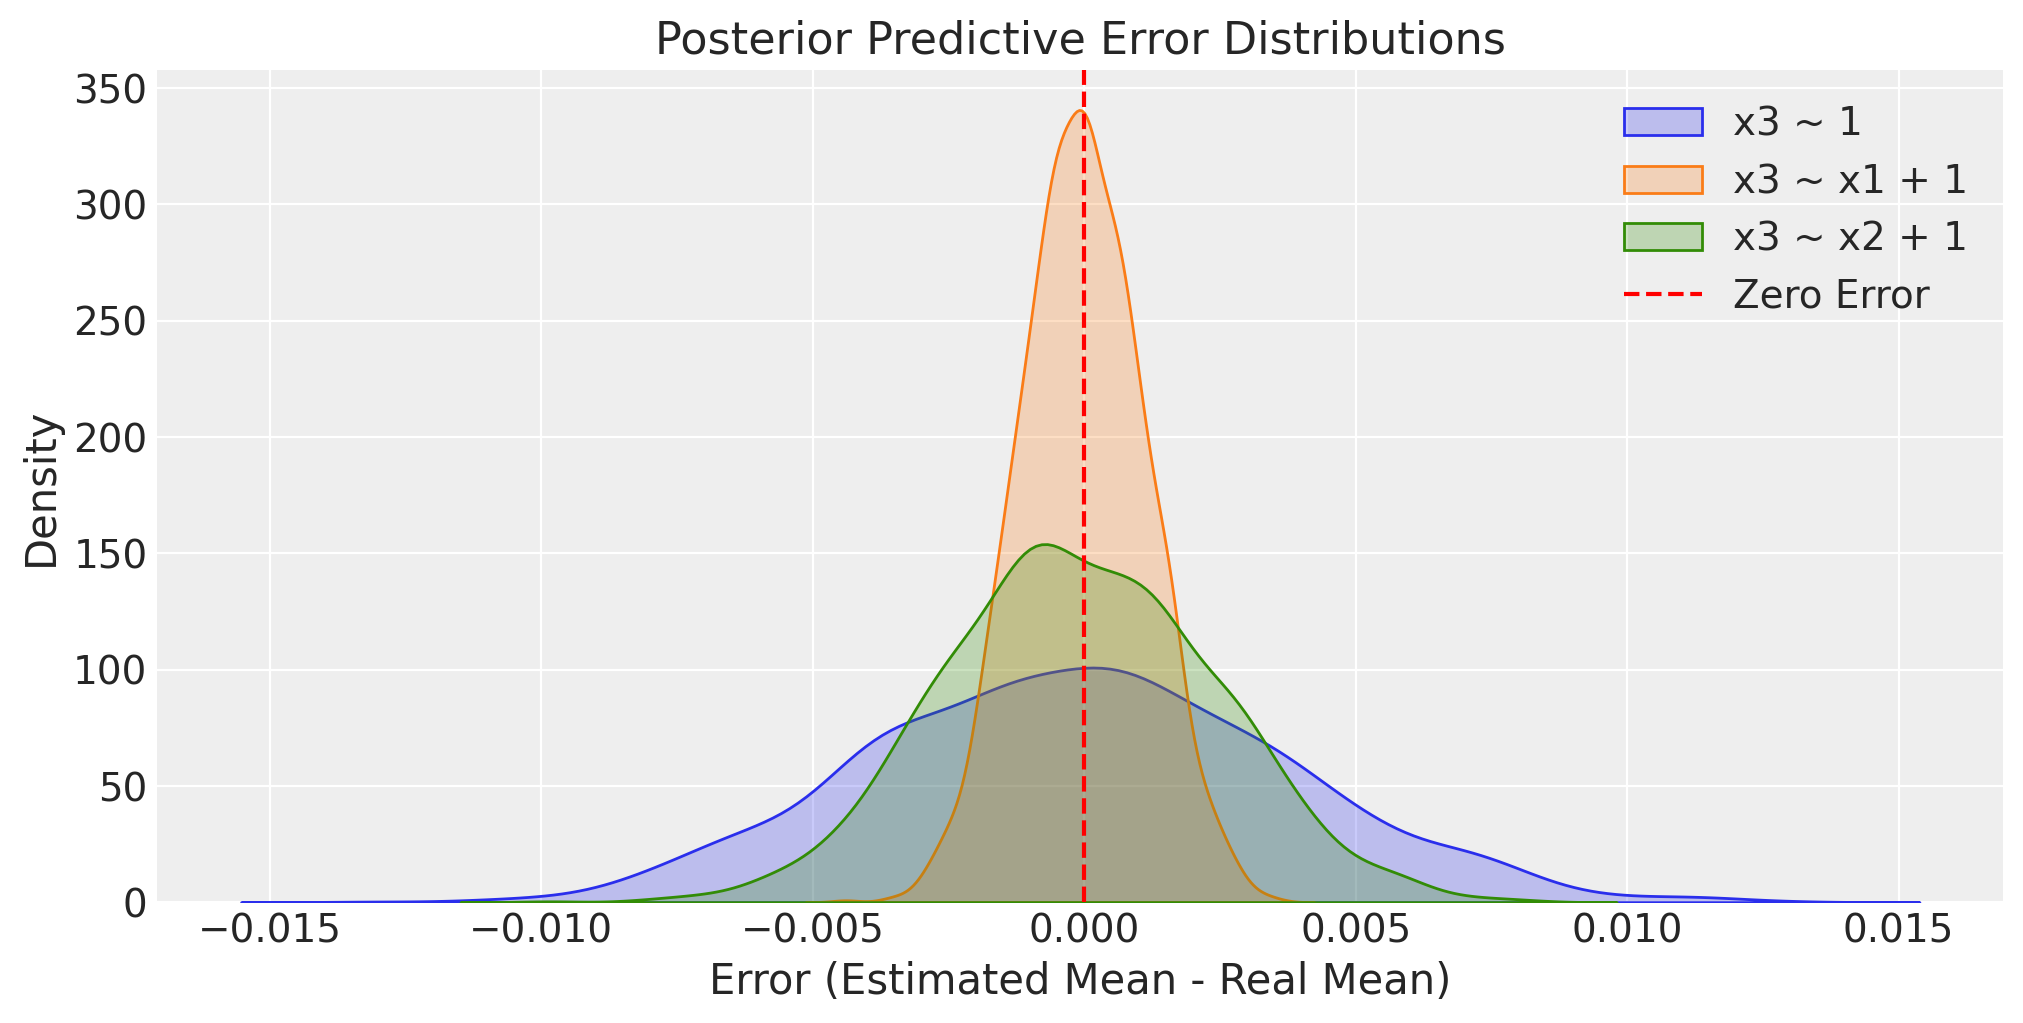

In [ ]:
identifier.plot_distributions()

Understanding the conditional independencies of the variables in our dataset allows us to identify the parents of each variable. Currently, we have identified that $x_3$ and $x_2$ are children of $x_1$, and $x_1$ is independent or truly exogenous.

We can now use this information to update our causal graph.

<ipython-input-37-5d272bca35a1>:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


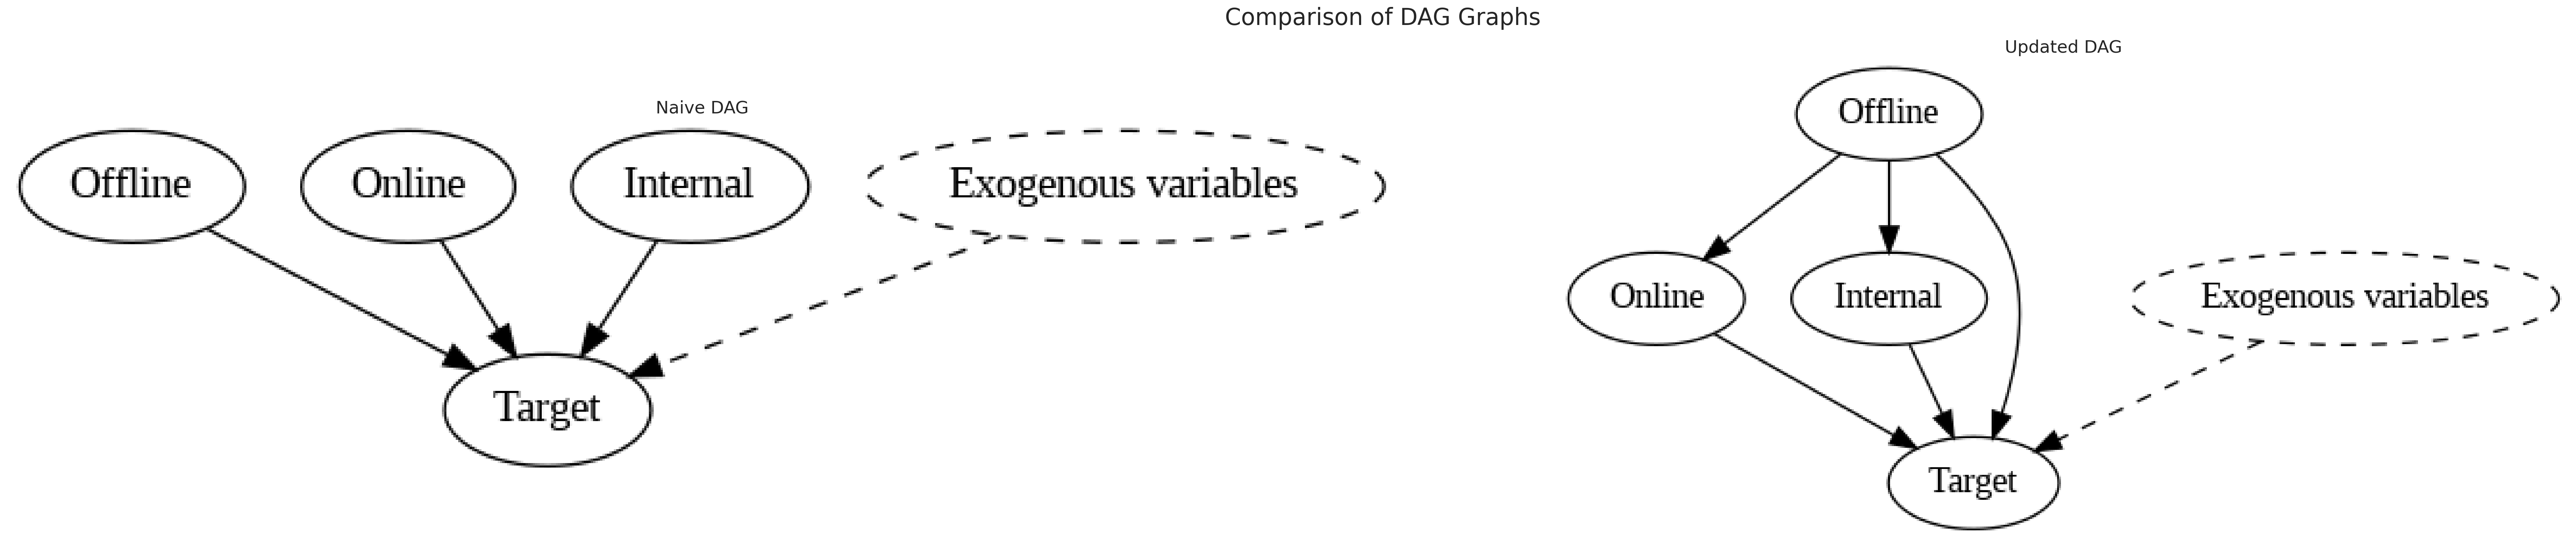

In [ ]:
# Initialize a directed graph
updated_naive_causal_mmm_graph = Digraph()

# Add nodes
updated_naive_causal_mmm_graph.node("X1", "Offline")
updated_naive_causal_mmm_graph.node("X2", "Online")
updated_naive_causal_mmm_graph.node("X3", "Internal")
updated_naive_causal_mmm_graph.node("E", "Exogenous variables", style="dashed")
updated_naive_causal_mmm_graph.node("T", "Target")

updated_naive_causal_mmm_graph.edge("E", "T", style="dashed")
updated_naive_causal_mmm_graph.edge("X1", "T")
updated_naive_causal_mmm_graph.edge("X1","X2")
updated_naive_causal_mmm_graph.edge("X1","X3")
updated_naive_causal_mmm_graph.edge("X2", "T")
updated_naive_causal_mmm_graph.edge("X3", "T")

# Create a figure with five subplots
fig, axes = plt.subplots(1, 2, figsize=(40, 8))

# Set titles for each subplot
titles = ["Naive DAG", "Updated DAG"]
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=18)
    ax.axis('off')

# Render and plot each graph
naive_causal_mmm_graph.render(format='png', filename='naive_dag')
axes[0].imshow(mpimg.imread('naive_dag.png'))

updated_naive_causal_mmm_graph.render(format='png', filename='updated_dag')
axes[1].imshow(mpimg.imread('updated_dag.png'))

# Add main title
plt.suptitle("Comparison of DAG Graphs", fontsize=24)
plt.tight_layout()

# Mediation analysis for the causal discovery

In mediation analysis, the total effect of a predictor $X1$ on a target $T$ is decomposed into direct and indirect components. The indirect effect operates through a mediator $M$, modeled as $M = \alpha_m + a \times X1 + \text{error}$. Simultaneously, the outcome is modeled as $T = \alpha_y + c' \times X1 + b \times M + \text{error}$. Here, the product $a \times b$ quantifies the indirect effect, while $c'$ represents the direct effect of $X1$ on $T$. By estimating these coefficients, we can assess whether the influence of $X1$ on $T$ is transmitted via $M$, entirely direct, or a combination of both. Statistical inference is performed using credible intervals, where intervals excluding zero indicate significant effects.

If the indirect effect $a \times b$ is significant and the direct effect $c'$ is not, we conclude that $X1$'s impact on $T$ is fully mediated by $M$. Conversely, significant values for both $a \times b$ and $c'$ suggest that $X1$ exerts both direct and indirect influences on $T$.

In simple terms, mediation analysis helps us determine whether a predictor $X1$ influences an outcome $T$ directly or mainly by first affecting a mediator $M$, which then impacts $T$. If the mediator's effect is significant while the direct effect is not, it suggests that $X1$ affects $T$ primarily through its influence on $M$.

In [ ]:
class MediationAnalysis:
    """
    A class for performing Bayesian mediation analysis using a joint mediation model.

    The model is specified as:
      Mediator:    M = α_m + a * X + error
      Outcome:     Y = α_y + c′ * X + b * M + error

    Derived parameters:
      - Indirect effect: ab = a * b
      - Total effect:    c  = c′ + (a * b)

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the predictor, mediator, and outcome variables.
    x : str
        Column name for the predictor (X).
    m : str
        Column name for the mediator (M).
    y : str
        Column name for the outcome (Y).
    hdi : float, optional
        Credible interval width for HDI (default 0.95).
    sampler_kwargs : dict, optional
        Additional keyword arguments for the sampler.
        Default: {"tune": 1000, "draws": 500, "chains": 4,
                  "random_seed": 42, "target_accept": 0.9,
                  "nuts_sampler": "numpyro", "progressbar": False}
    """
    def __init__(self, data: pd.DataFrame, x: str, m: str, y: str, hdi: float = 0.95, sampler_kwargs: dict = None):
        self.data = data
        self.x = x
        self.m = m
        self.y = y
        self.hdi = hdi
        self.sampler_kwargs = sampler_kwargs or {
            "tune": 1000,
            "draws": 500,
            "chains": 4,
            "random_seed": 42,
            "target_accept": 0.9,
            "nuts_sampler": "numpyro",
            "progressbar": False
        }
        self.idata = None
        self.model = None

    def build_model(self):
        """
        Build the Bayesian mediation model.

        This method constructs the PyMC model and stores it in self.model.

        Returns
        -------
        model : pm.Model
            The constructed PyMC model.
        """
        # Extract data arrays
        X_data = self.data[self.x].values
        M_data = self.data[self.m].values
        Y_data = self.data[self.y].values
        N = len(self.data)
        coords = {"obs": range(N)}

        with pm.Model(coords=coords) as model:
            # Mediator path: M = α_m + a * X + error
            alpha_m = pm.Normal("alpha_m", mu=0.0, sigma=1.0)
            a = pm.Normal("a", mu=0.0, sigma=1.0)
            sigma_m = pm.Exponential("sigma_m", lam=1.0)
            mu_m = alpha_m + a * X_data
            pm.Normal("M_obs", mu=mu_m, sigma=sigma_m, observed=M_data, dims="obs")

            # Outcome path: Y = α_y + c′ * X + b * M + error
            alpha_y = pm.Normal("alpha_y", mu=0.0, sigma=1.0)
            c_prime = pm.Normal("c_prime", mu=0.0, sigma=1.0)
            b = pm.Normal("b", mu=0.0, sigma=1.0)
            sigma_y = pm.Exponential("sigma_y", lam=1.0)
            mu_y = alpha_y + c_prime * X_data + b * M_data
            pm.Normal("Y_obs", mu=mu_y, sigma=sigma_y, observed=Y_data, dims="obs")

            # Derived parameters: indirect and total effects
            pm.Deterministic("ab", a * b)
            pm.Deterministic("c", c_prime + a * b)

        self.model = model

    def fit(self):
        """
        Sample from the previously built mediation model.

        Returns
        -------
        self : MediationAnalysis
            The fitted mediation analysis object.

        Raises
        ------
        ValueError
            If the model has not been built yet.
        """
        if self.model is None:
            raise ValueError("The model has not been built. Call build_model() before fit().")

        with self.model:
            self.idata = pm.sample(**self.sampler_kwargs)


    def get_summary(self):
        """
        Get a numerical summary of the mediation parameters.

        Returns
        -------
        dict
            Dictionary with mean estimates and HDI bounds for each parameter.
        """
        var_names = ["alpha_m", "a", "alpha_y", "c_prime", "b", "ab", "c"]
        summary_df = az.summary(self.idata, var_names=var_names, hdi_prob=self.hdi)

        # Compute the HDI column names based on the specified interval
        lower_percent = (1 - self.hdi) / 2 * 100
        upper_percent = 100 - lower_percent
        lower_col = f"hdi_{lower_percent:.1f}%"
        upper_col = f"hdi_{upper_percent:.1f}%"

        results = {}
        for key in var_names:
            results[key] = {
                "mean": summary_df.loc[key, "mean"],
                "hdi_lower": summary_df.loc[key, lower_col],
                "hdi_upper": summary_df.loc[key, upper_col]
            }
        return results

    def get_report(self, x_label: str = None, m_label: str = None, y_label: str = None):
        """
        Generate a plain-language report of the mediation analysis results.

        Parameters
        ----------
        x_label : str, optional
            Label for the predictor variable (default uses self.x).
        m_label : str, optional
            Label for the mediator variable (default uses self.m).
        y_label : str, optional
            Label for the outcome variable (default uses self.y).

        Returns
        -------
        str
            A human-readable summary of the mediation effects.
        """
        # Use provided labels or default to variable names
        x_label = x_label or self.x
        m_label = m_label or self.m
        y_label = y_label or self.y

        var_names = ["a", "b", "c_prime", "ab", "c"]
        summary_df = az.summary(self.idata, var_names=var_names, hdi_prob=self.hdi)

        def hdi_includes_zero(row):
            lower_percent = (1 - self.hdi) / 2 * 100
            upper_percent = 100 - lower_percent
            lower_col = f"hdi_{lower_percent:.1f}%"
            upper_col = f"hdi_{upper_percent:.1f}%"
            return row[lower_col] <= 0 <= row[upper_col]

        # Extract summary statistics
        a_stats = summary_df.loc["a"]
        b_stats = summary_df.loc["b"]
        c_prime_stats = summary_df.loc["c_prime"]
        ab_stats = summary_df.loc["ab"]
        c_stats = summary_df.loc["c"]

        a_mean = a_stats["mean"]
        b_mean = b_stats["mean"]
        c_prime_mean = c_prime_stats["mean"]
        ab_mean = ab_stats["mean"]
        c_mean = c_stats["mean"]

        a_zero = hdi_includes_zero(a_stats)
        b_zero = hdi_includes_zero(b_stats)
        c_prime_zero = hdi_includes_zero(c_prime_stats)
        ab_zero = hdi_includes_zero(ab_stats)
        c_zero = hdi_includes_zero(c_stats)

        lines = []
        lines.append(f"**Bayesian Mediation Analysis Overview** ({int(self.hdi * 100)}% HDI)")
        lines.append(f"Variables: {x_label} (predictor), {m_label} (mediator), {y_label} (outcome).")

        # Interpret each path
        if not a_zero:
            direction = "positive" if a_mean > 0 else "negative"
            lines.append(f"- Path a ({x_label} → {m_label}) is credibly {direction} (mean = {a_mean:.3f}).")
        else:
            lines.append(f"- Path a ({x_label} → {m_label}) is weak (HDI includes 0, mean = {a_mean:.3f}).")

        if not b_zero:
            direction = "positive" if b_mean > 0 else "negative"
            lines.append(f"- Path b ({m_label} → {y_label}, controlling for {x_label}) is credibly {direction} (mean = {b_mean:.3f}).")
        else:
            lines.append(f"- Path b ({m_label} → {y_label}, controlling for {x_label}) is weak (HDI includes 0, mean = {b_mean:.3f}).")

        if not ab_zero:
            direction = "positive" if ab_mean > 0 else "negative"
            lines.append(f"- Indirect effect (a×b) is credibly {direction} (mean = {ab_mean:.3f}).")
        else:
            lines.append(f"- Indirect effect (a×b) is uncertain (HDI includes 0, mean = {ab_mean:.3f}).")

        if not c_prime_zero:
            direction = "positive" if c_prime_mean > 0 else "negative"
            lines.append(f"- Direct effect (c') is credibly {direction} (mean = {c_prime_mean:.3f}).")
        else:
            lines.append(f"- Direct effect (c') is near zero (HDI includes 0, mean = {c_prime_mean:.3f}).")

        if not c_zero:
            direction = "positive" if c_mean > 0 else "negative"
            lines.append(f"- Total effect (c) is credibly {direction} (mean = {c_mean:.3f}).")
        else:
            lines.append(f"- Total effect (c) is uncertain (HDI includes 0, mean = {c_mean:.3f}).")

        lines.append("")
        if not ab_zero and c_prime_zero:
            lines.append(f"It appears that {m_label} fully mediates the effect of {x_label} on {y_label} (indirect effect is non-zero while direct effect is near zero).")
        elif not ab_zero and not c_prime_zero:
            lines.append(f"It appears that {m_label} partially mediates the effect of {x_label} on {y_label} (both indirect and direct effects are credibly non-zero).")
        else:
            lines.append("Mediation is unclear or absent (the indirect effect includes zero or the total effect is not clearly different from zero).")

        return "\n".join(lines)

In [ ]:
analysis1 = MediationAnalysis(data=scaled_df, x="x1", m="x2", y="y")

# First, build the model
analysis1.build_model()

# Then, sample from the built model
analysis1.fit()

# Get a numerical summary
analysis1.get_summary()

# Get a plain-language report
print(analysis1.get_report())

**Bayesian Mediation Analysis Overview** (95% HDI)
Variables: x1 (predictor), x2 (mediator), y (outcome).
- Path a (x1 → x2) is credibly positive (mean = 0.411).
- Path b (x2 → y, controlling for x1) is credibly positive (mean = 0.628).
- Indirect effect (a×b) is credibly positive (mean = 0.258).
- Direct effect (c') is near zero (HDI includes 0, mean = 0.006).
- Total effect (c) is credibly positive (mean = 0.264).

It appears that x2 fully mediates the effect of x1 on y (indirect effect is non-zero while direct effect is near zero).


In [ ]:
analysis2 = MediationAnalysis(data=scaled_df, x="x1", m="x3", y="y")

# First, build the model
analysis2.build_model()

# Then, sample from the built model
analysis2.fit()

# Get a numerical summary
analysis2.get_summary()

# Get a plain-language report
print(analysis2.get_report())

**Bayesian Mediation Analysis Overview** (95% HDI)
Variables: x1 (predictor), x3 (mediator), y (outcome).
- Path a (x1 → x3) is credibly positive (mean = 0.390).
- Path b (x3 → y, controlling for x1) is credibly positive (mean = 0.362).
- Indirect effect (a×b) is credibly positive (mean = 0.141).
- Direct effect (c') is credibly positive (mean = 0.123).
- Total effect (c) is credibly positive (mean = 0.265).

It appears that x3 partially mediates the effect of x1 on y (both indirect and direct effects are credibly non-zero).


Great based on the following results we can conclude that $x_1$ affects $y$ through $x_2$ and $x_3$ but not directly. This conclusion is based on the indirect effect being significant and the direct effect being near zero when controlling for the mediator $x2$ and partial for $x3$.

If both factor were present, the indirect effect would be stronger, given the previous results. So, for simplicity, we'll not test the mediation when both factors are present.

We can again, update our causal graph to reflect the new findings.

<ipython-input-41-5354ff9828be>:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


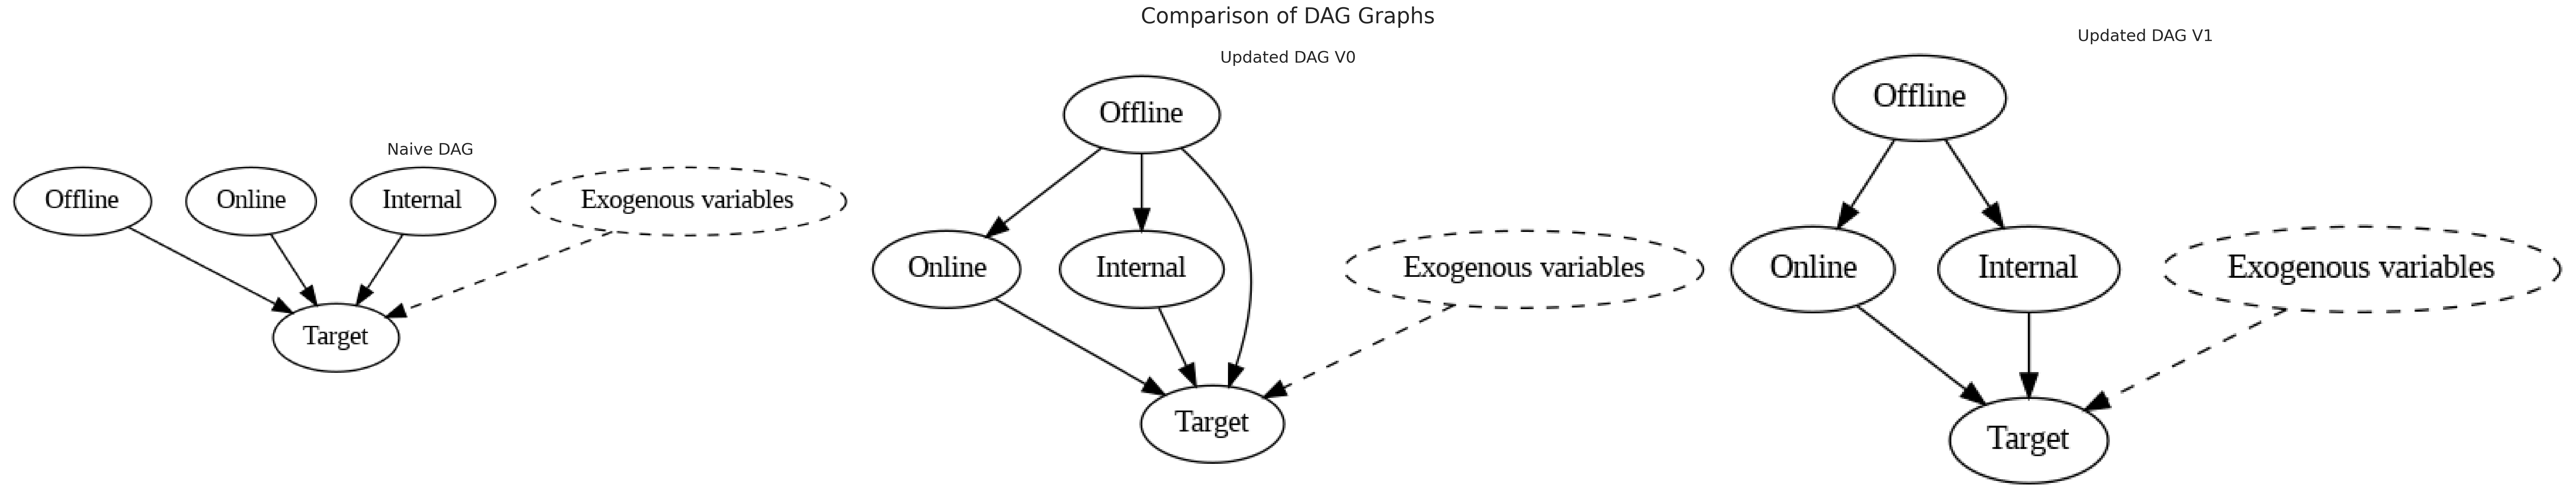

In [ ]:
# Initialize a directed graph
updated_naive_causal_mmm_graph1 = Digraph()

# Add nodes
updated_naive_causal_mmm_graph1.node("X1", "Offline")
updated_naive_causal_mmm_graph1.node("X2", "Online")
updated_naive_causal_mmm_graph1.node("X3", "Internal")
updated_naive_causal_mmm_graph1.node("E", "Exogenous variables", style="dashed")
updated_naive_causal_mmm_graph1.node("T", "Target")

updated_naive_causal_mmm_graph1.edge("E", "T", style="dashed")
updated_naive_causal_mmm_graph1.edge("X1","X2")
updated_naive_causal_mmm_graph1.edge("X1","X3")
updated_naive_causal_mmm_graph1.edge("X2", "T")
updated_naive_causal_mmm_graph1.edge("X3", "T")

# Create a figure with five subplots
fig, axes = plt.subplots(1, 3, figsize=(40, 8))

# Set titles for each subplot
titles = ["Naive DAG", "Updated DAG V0", "Updated DAG V1"]
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=18)
    ax.axis('off')

# Render and plot each graph
naive_causal_mmm_graph.render(format='png', filename='naive_dag')
axes[0].imshow(mpimg.imread('naive_dag.png'))

updated_naive_causal_mmm_graph.render(format='png', filename='updated_dag')
axes[1].imshow(mpimg.imread('updated_dag.png'))

updated_naive_causal_mmm_graph1.render(format='png', filename='updated_dag')
axes[2].imshow(mpimg.imread('updated_dag.png'))

# Add main title
plt.suptitle("Comparison of DAG Graphs", fontsize=24)
plt.tight_layout()

This is great! Our new causal graph is more complex, but it is more accurate to the one defined before. Nevertheless, we need a significant amount of time, and manual work to arrive to this conclusion.

How could we automate this process? It's even possible? and how this would solve the intial problem?

Yes, it is possible! We can use causal discovery algorithms to automate this process.

# Introduction to causal discovery
Causal discovery infers directional cause-and-effect relationships from observational data. It uses computational algorithms to construct directed acyclic graphs that represent potential causal mechanisms. These techniques are based on the causal Markov condition and the assumption of statistical faithfulness. They employ statistical tests for conditional independence to differentiate direct influences from indirect associations. This approach integrates statistical inference and graph theory to model complex systems. Overall, it uncovers hidden causal structures that enhance our understanding and estimations of dynamic phenomena.

> Causal Markov Assumption: Each variable is independent of its non-effects given its direct causes, meaning that the joint probability distribution can be factorized according to the directed acyclic graph structure. This implies that once you condition on a variable's immediate causes, any further upstream or parallel influences are rendered statistically irrelevant.

> Statistical Faithfulness: This assumption posits that all and only the conditional independence relations observed in the data are those implied by the causal graph. In other words, there are no accidental cancellations or coincidental independencies beyond what the causal structure predicts.

In [ ]:
class CausalDiscovery:
    def __init__(self, data):
        self.data = data
        self.labels = [f'{col}' for col in data.columns.to_list()]

    def greedy_search(self, **kwargs):
        result = ges(X=self.data.to_numpy(), **kwargs)
        return result["G"]

    def peter_clark(self, **kwargs):
        result = pc(self.data.to_numpy(), **kwargs)
        return result.G

    def to_pydot(self, graph):
        return GraphUtils.to_pydot(graph, labels=self.labels)

    def to_dict(self, graph):
        """
        Convert a general graph to a dictionary representation where each node is a key
        and the value is a list of its descendants.

        Parameters
        ----------
        graph : causallearn.graph.GeneralGraph.GeneralGraph
            The input graph.

        Returns
        -------
        dict
            A dictionary where keys are node labels and values are lists of descendant node labels.
        """
        result = {}
        nodes = sorted(graph.get_nodes(), key=lambda x: str(x))

        # Initialize the dictionary with empty lists for all nodes
        for i, node in enumerate(nodes):
            result[self.labels[i]] = []

        # For each node, find its children (direct descendants)
        for i, node in enumerate(nodes):
            node_label = self.labels[i]
            for j, potential_child in enumerate(nodes):
                if i != j and graph.get_edge(node, potential_child) is not None:
                    # Check if there's a directed edge from node to potential_child
                    edge = graph.get_edge(node, potential_child)
                    if (edge.get_endpoint1() == Endpoint.TAIL and
                        edge.get_endpoint2() == Endpoint.ARROW):
                        result[node_label].append(self.labels[j])

        return result


    def to_graphviz(self, graph, handle_circle="skip"):
        """
        Convert a general graph into a Graphviz Digraph using the pydot conversion
        for nodes while preserving the original directed edge ordering.

        Only if the original graph indicates that an edge is undirected (both endpoints
        are TAIL) do we override the arrow style (using dir="none"). Otherwise, we leave
        the pydot-provided direction unchanged.

        Parameters
        ----------
        graph : causallearn.graph.GeneralGraph.GeneralGraph
            The input graph.
        handle_circle : str, optional
            How to handle circle endpoints (not used explicitly here but available for future logic).

        Returns
        -------
        graphviz.Digraph
            A Graphviz Digraph where undirected edges are rendered without arrowheads.
        """
        # Get the pydot graph (for node positions/labels)
        dot = self.to_pydot(graph)
        digraph = Digraph()
        digraph.attr(size='8,8')

        # Build a mapping of the original graph nodes based on sorted order.
        original_nodes = sorted(graph.get_nodes(), key=lambda x: str(x))
        # Map string indices ("0", "1", …) to the original nodes.
        index_to_node = {str(i): node for i, node in enumerate(original_nodes)}
        # Map indices to labels using self.labels.
        node_labels = {str(i): self.labels[i] for i in range(len(original_nodes))}

        # Add nodes to the Graphviz Digraph.
        for idx_str, label in node_labels.items():
            digraph.node(label)

        # Process each edge from the pydot graph.
        processed = set()
        pydot_edges = dot.get_edges()

        for edge in pydot_edges:
            # Get source and destination from pydot.
            src_raw = edge.get_source()
            dst_raw = edge.get_destination()
            src_str = src_raw.strip('"') if isinstance(src_raw, str) else str(src_raw)
            dst_str = dst_raw.strip('"') if isinstance(dst_raw, str) else str(dst_raw)

            # Get original node objects using our mapping.
            src_node = index_to_node.get(src_str)
            dst_node = index_to_node.get(dst_str)
            if src_node is None or dst_node is None:
                continue

            # Get display labels.
            src_label = node_labels.get(src_str, src_str)
            dst_label = node_labels.get(dst_str, dst_str)

            # Use a tuple (src_str, dst_str) to ensure we don't add duplicates.
            edge_key = (src_str, dst_str)
            reverse_key = (dst_str, src_str)
            if edge_key in processed or reverse_key in processed:
                continue

            try:
                # Get endpoint information from the original graph.
                e_uv = graph.get_endpoint(src_node, dst_node)
                e_vu = graph.get_endpoint(dst_node, src_node)
            except KeyError:
                # Skip if the original graph doesn't contain this edge.
                continue

            # If both endpoints are TAIL, we treat the edge as undirected.
            if e_uv == Endpoint.TAIL and e_vu == Endpoint.TAIL:
                digraph.edge(src_label, dst_label, dir="none")
                processed.add(edge_key)
                processed.add(reverse_key)
            else:
                # Otherwise, preserve the original pydot direction.
                digraph.edge(src_label, dst_label)
                processed.add(edge_key)

        return digraph

    def to_networkx(self, graph) -> nx.DiGraph:
        """
        Convert a general graph (e.g. from causallearn) into a NetworkX DiGraph.

        Nodes are added as provided by graph.get_nodes(), and for each ordered pair (u, v)
        where an edge exists (as determined by graph.get_endpoint(u, v)), we add a directed
        edge with an attribute 'endpoint' that stores the edge marker.

        If the general graph does not provide a direct list of edges (e.g. via a get_edges() method),
        we iterate over all pairs of nodes.
        """
        digraph = nx.DiGraph()
        nodes = graph.get_nodes()
        # Add nodes to the networkx graph.
        for node in nodes:
            digraph.add_node(node)

        # If available, use a dedicated method to get edges.
        try:
            edges = graph.get_edges()
        except AttributeError:
            # Fallback: iterate over all ordered pairs (inefficient for large graphs)
            edges = []
            for u in nodes:
                for v in nodes:
                    if u == v:
                        continue
                    try:
                        # Attempt to get an endpoint; if present, we consider that an edge exists.
                        _ = graph.get_endpoint(u, v)
                        edges.append((u, v))
                    except KeyError:
                        continue

        # Add edges with endpoint attributes.
        for u, v in edges:
            try:
                endpoint_uv = graph.get_endpoint(u, v)
            except KeyError:
                continue
            digraph.add_edge(u, v, endpoint=endpoint_uv)

        return digraph

    def _networkx_to_graphviz(self, nx_graph: nx.DiGraph) -> Digraph:
        """
        Convert a NetworkX DiGraph into a Graphviz Digraph.

        This method uses similar logic to 'to_graphviz', checking for reciprocal edges.
        If an edge (u,v) and its reverse (v,u) exist and both have the attribute endpoint
        equal to Endpoint.TAIL, the edge is rendered as undirected (dir="none").
        """
        digraph = Digraph()
        digraph.attr(size='8,8')
        processed = set()

        # Sort nodes to create a consistent mapping with self.labels.
        sorted_nodes = sorted(nx_graph.nodes(), key=lambda x: str(x))
        node_labels = {}
        for i, node in enumerate(sorted_nodes):
            # Use self.labels if available, otherwise default to the node's string representation.
            label = self.labels[i] if i < len(self.labels) else str(node)
            node_labels[node] = label
            digraph.node(label)

        for u, v in nx_graph.edges():
            if (u, v) in processed or (v, u) in processed:
                continue
            src_label = node_labels.get(u, str(u))
            dst_label = node_labels.get(v, str(v))

            # Check if the reverse edge exists to potentially mark as undirected.
            if nx_graph.has_edge(v, u):
                endpoint_uv = nx_graph.edges[u, v].get('endpoint', None)
                endpoint_vu = nx_graph.edges[v, u].get('endpoint', None)
                if endpoint_uv == Endpoint.TAIL and endpoint_vu == Endpoint.TAIL:
                    digraph.edge(src_label, dst_label, dir="none")
                    processed.add((u, v))
                    processed.add((v, u))
                    continue
            # Otherwise, add the edge as directed.
            digraph.edge(src_label, dst_label)
            processed.add((u, v))

        return digraph

    def _graphviz_to_networkx(self, gv_graph: Digraph) -> nx.DiGraph:
        """
        Convert a Graphviz Digraph into a NetworkX DiGraph.

        This method extracts the DOT source from the provided Graphviz Digraph,
        parses it using pydot, and then converts the resulting pydot graph into
        a NetworkX directed graph. This ensures that node labels and edge orientations
        are maintained consistently.

        Parameters
        ----------
        gv_graph : graphviz.Digraph
            The Graphviz Digraph to be converted.

        Returns
        -------
        nx.DiGraph
            A NetworkX DiGraph representation of the input Graphviz graph.
        """
        # Retrieve the DOT source code from the Graphviz Digraph.
        dot_str = gv_graph.source

        # Parse the DOT data using pydot.
        pydot_graphs = pydot.graph_from_dot_data(dot_str)
        if not pydot_graphs:
            raise ValueError("No valid pydot graphs could be parsed from the DOT data.")
        # pydot.graph_from_dot_data returns a list; we take the first one.
        pydot_graph = pydot_graphs[0]

        # Use NetworkX’s built-in conversion from a pydot graph to a DiGraph.
        nx_graph = nx.nx_pydot.from_pydot(pydot_graph)
        return nx_graph

Causal Learn allows use to use different algorithms to infer the markov equivalent class of the causal graph. The previous class is a wrapper that allows us to use the different algorithms implemented in the causal learn library, and plot them more easily.

Currently we wrap the following algorithms:

- Greedy Search (GES)
- Peter-Clark (PC)

-----
The **Peter-Clark algorithm** is a constraint-based method that infers causal structures from observational data using conditional independence tests. It starts with a fully connected undirected graph where every variable is initially connected to every other variable. The algorithm systematically tests conditional independence between pairs of variables, conditioning on increasingly larger subsets of other variables. When a conditional independence is detected, the corresponding edge is removed from the graph.

On the other hand, **Greedy Search** is a score-based method that iteratively improves a candidate causal model by locally modifying its structure. It begins with an initial directed acyclic graph and evaluates a scoring metric that balances goodness-of-fit with model complexity. The algorithm explores modifications such as adding, deleting, or reversing edges to find local improvements in the score. At each iteration, it selects the change that produces the highest increase in the score, following a step-by-step improvement strategy. The search continues until no single modification can further enhance the model’s score. This method efficiently navigates the combinatorial search space of possible graphs by making locally optimal choices.

-----

> IMPORTANT: Any causal discovery algorithm is based on the assumption that all the relevant variables are observed. If some relevant variable is not observed, the algorithm will not be able to infer the correct causal graph. Each variable, even the unobserved ones, should be represented in the dataset, so the algorithm can include them in the causal graph and validation tests.

The following example shows the causal graph inferred using the Greedy Search algorithm.

In [ ]:
causal_model = CausalDiscovery(scaled_df[["holiday_signal", "inflation", "x1", "x2", "x3", "y"]])
ges_graph = causal_model.greedy_search()

<ipython-input-44-5dd0dbaa7a77>:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


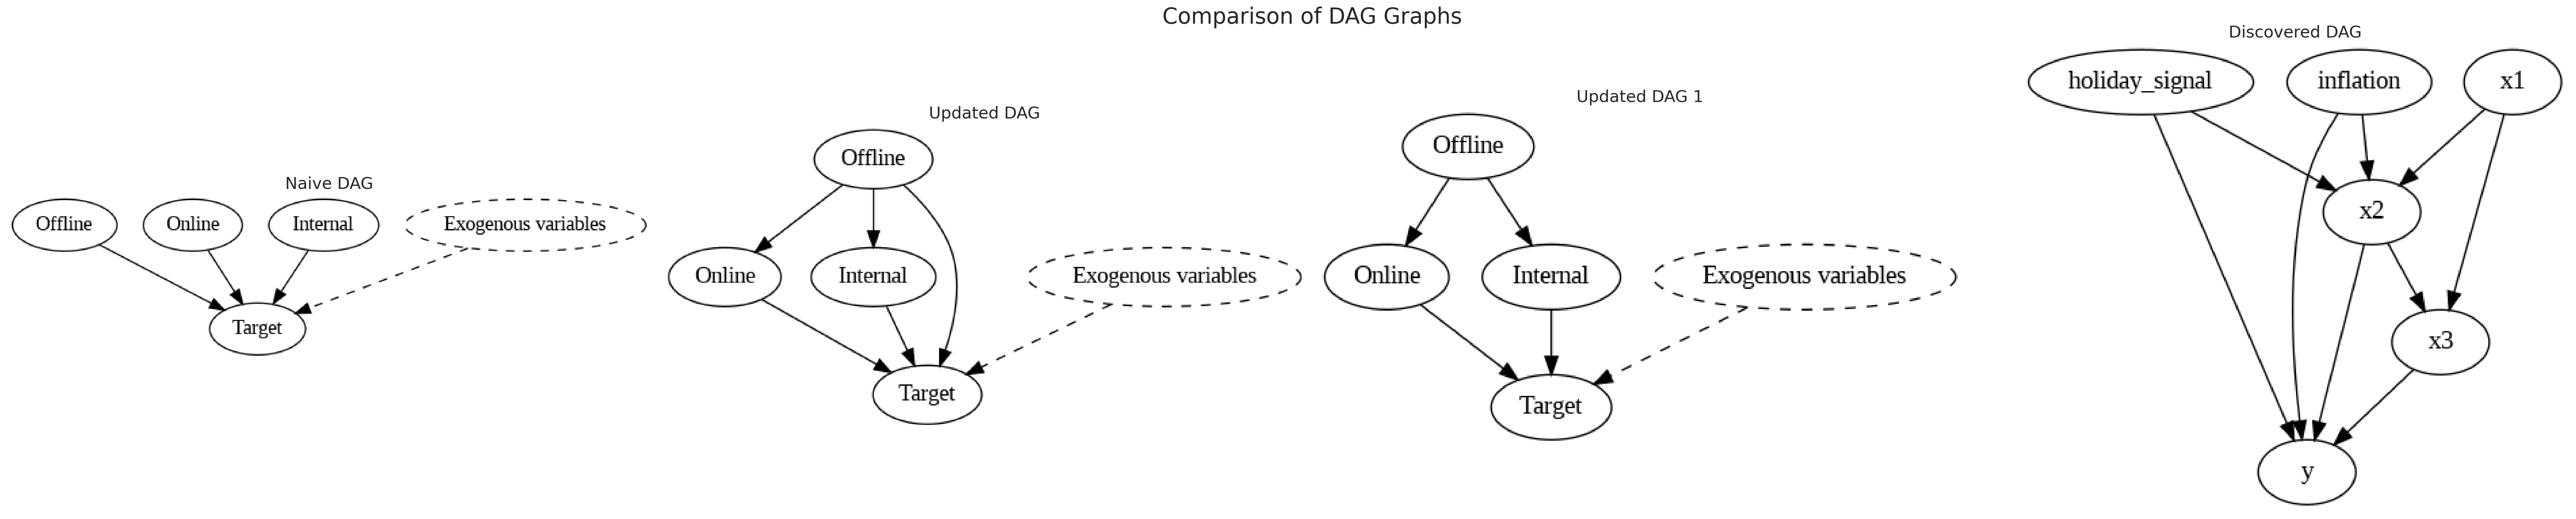

In [ ]:
# Create a figure with five subplots
fig, axes = plt.subplots(1, 4, figsize=(40, 8))

# Set titles for each subplot
titles = ["Naive DAG", "Updated DAG", "Updated DAG 1", "Discovered DAG", "True DAG"]
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=18)
    ax.axis('off')

# Render and plot each graph
naive_causal_mmm_graph.render(format='png', filename='naive_dag')
axes[0].imshow(mpimg.imread('naive_dag.png'))

updated_naive_causal_mmm_graph.render(format='png', filename='updated_dag')
axes[1].imshow(mpimg.imread('updated_dag.png'))

updated_naive_causal_mmm_graph1.render(format='png', filename='updated_dag1')
axes[2].imshow(mpimg.imread('updated_dag1.png'))

real_dag_graph = causal_model.to_graphviz(ges_graph)
real_dag_graph.render(format='png', filename='discovered_dag')
axes[3].imshow(mpimg.imread('discovered_dag.png'))

# Add main title
plt.suptitle("Comparison of DAG Graphs", fontsize=24)
plt.tight_layout()

Great, the causal graph capture by greedy search is very similar to the true causal graph. Some arrows are directed to variables that are not related, but this is expected given the nature of the data, we still have noise in the data, and sporious correlations that can't be fully falsify by the independence tests. Additionally, the finded graph can lie in the markov equivalence class of the true causal graph, meaning that there are multiple DAGs that are compatible with the data.

This instead of being a problem, is a great news because we can now start to work with experimentation to test the current structure, and improve it iteratively, without the need to wait for these answers to get the right estimates in a regression model.

Let's break down the causal paths from x2 to y in the graph:

**Confounding paths:**

- Holiday: Affects both x2 and y (holiday → x2 and holiday → y).
- Inflation: Affects both x2 and y (inflation → x2 and inflation → y).
- x1: Influences x2 (x1 → x2) and also affects y indirectly through x3 (x1 → x3 → y).

**Mediating path:**

- x3: Lies on the causal pathway from x2 to y (x2 → x3 → y).

**What needs to be controlled?**

To estimate the total effect of x2 on y without bias, you need to block all backdoor (confounding) paths. This means controlling for the common causes:

- Holiday
- Inflation
- x1

**Why not control for x3?**
Since x3 is a mediator (i.e., it transmits part of the effect of x2 to y), including it in your regression would block the indirect effect of x2 on y. This “over-control” would result in an estimate that reflects only the direct effect of x2 on y, not the total effect. Additionally, controlling for mediators can sometimes introduce bias if there are other complex relationships in the graph.

In [ ]:
mmm = MMM(
    model_config=model_config,
    date_column="date",
    channel_columns=[
        "x1",
        # "x2",
        "x3"
    ],
    control_columns=[
        "holiday_signal",
        "inflation",
    ],
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
)

mmm.fit(X, y, **fit_kwargs)
mmm.sample_posterior_predictive(
    X=X,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

<xarray.Dataset> Size: 17MB
Dimensions:  (sample: 2000, date: 1041)
Coordinates:
  * date     (date) datetime64[ns] 8kB 2022-01-01 2022-01-02 ... 2024-11-06
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 17MB 10.66 9.925 9.543 ... 6.759 6.981 7.737
Attributes:
    created_at:                 2025-03-07T11:47:45.794126+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [ ]:
#summary of model idata
az.summary(mmm.idata, var_names=["saturation_alpha", "saturation_lam", "adstock_alpha", "gamma_control"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
saturation_alpha[x1]           0.362  0.086   0.213    0.520      0.003   
saturation_alpha[x3]           1.064  0.137   0.832    1.341      0.005   
saturation_lam[x1]             2.168  0.580   1.192    3.301      0.020   
saturation_lam[x3]             0.983  0.491   0.311    1.892      0.020   
adstock_alpha[x1]              0.549  0.090   0.385    0.697      0.004   
adstock_alpha[x3]              0.297  0.082   0.150    0.466      0.003   
gamma_control[holiday_signal]  0.237  0.004   0.230    0.244      0.000   
gamma_control[inflation]      -0.050  0.001  -0.052   -0.049      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
saturation_alpha[x1]             0.002     738.0     954.0    1.0  
saturation_alpha[x3]             0.004     732.0     614.0    1.0  
saturation_lam[x1]               0.014     824.0    1117.0    1.0  
saturation_lam[x3]               0.014     557.0     754.0    1.0  
adstock_alpha[x1]                0.003     751.0     465.0    1.0  
adstock_alpha[x3]                0.002     616.0     570.0    1.0  
gamma_control[holiday_signal]    0.000    1584.0    1179.0    1.0  
gamma_control[inflation]         0.000    2565.0    1440.0    1.0

In [ ]:
initial_model_recover_effect = (
    az.hdi(mmm.fit_result["channel_contribution"], hdi_prob=0.95)
    * mmm.target_transformer["scaler"].scale_.item()
)
initial_model_mean_effect = (
    mmm.fit_result.channel_contribution.mean(dim=["chain", "draw"])
    * mmm.target_transformer["scaler"].scale_.item()
)

In [ ]:
def plot_posterior(y_real, posterior, figsize=(15, 8), path_color='orange', hist_color='orange', **kwargs):
    """
    Plot the posterior distribution of a stochastic process.

    Parameters:
    posterior (xarray.DataArray): The posterior distribution with shape (draw, chain, date).
    figsize (tuple): Size of the figure.
    path_color (str): Color of the paths in the time series plot.
    hist_color (str): Color of the histogram.
    **kwargs: Additional keyword arguments to pass to the plotting functions.
    """

    # Calculate the expected value (mean) across all draws and chains for each date
    expected_value = posterior.mean(dim=("draw", "chain"))

    # Create a figure and a grid of subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

    # Time series plot
    ax1 = fig.add_subplot(gs[0])
    for chain in range(posterior.shape[1]):
        for draw in range(0, posterior.shape[0], 10):  # Plot every 10th draw for performance
            ax1.plot(posterior.date, posterior[draw, chain], color=path_color, alpha=0.1, linewidth=0.5)

    ax1.plot(posterior.date, expected_value, color='grey', linestyle='--', linewidth=2)
    ax1.plot(posterior.date, y_real, color='black', linestyle='-', linewidth=2, label='Real',)
    ax1.set_title("Posterior Predictive")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value')
    ax1.grid(True)
    ax1.legend()

    # KDE plot
    ax2 = fig.add_subplot(gs[1])
    final_values = posterior[:, :, -1].values.flatten()

    # Use seaborn for KDE plot
    sns.kdeplot(y=final_values, ax=ax2, fill=True, color=hist_color, alpha=0.6, **kwargs)

    # Add histogram on top of KDE
    ax2.hist(final_values, orientation='horizontal', color=hist_color, bins=30,
             alpha=0.3, density=True)

    ax2.axhline(y=expected_value[-1], color='grey', linestyle='--', linewidth=2)
    ax2.set_title('Distribution at T')
    ax2.set_xlabel('Density')
    ax2.set_yticklabels([])  # Hide y tick labels to avoid duplication
    ax2.grid(True)
    return fig

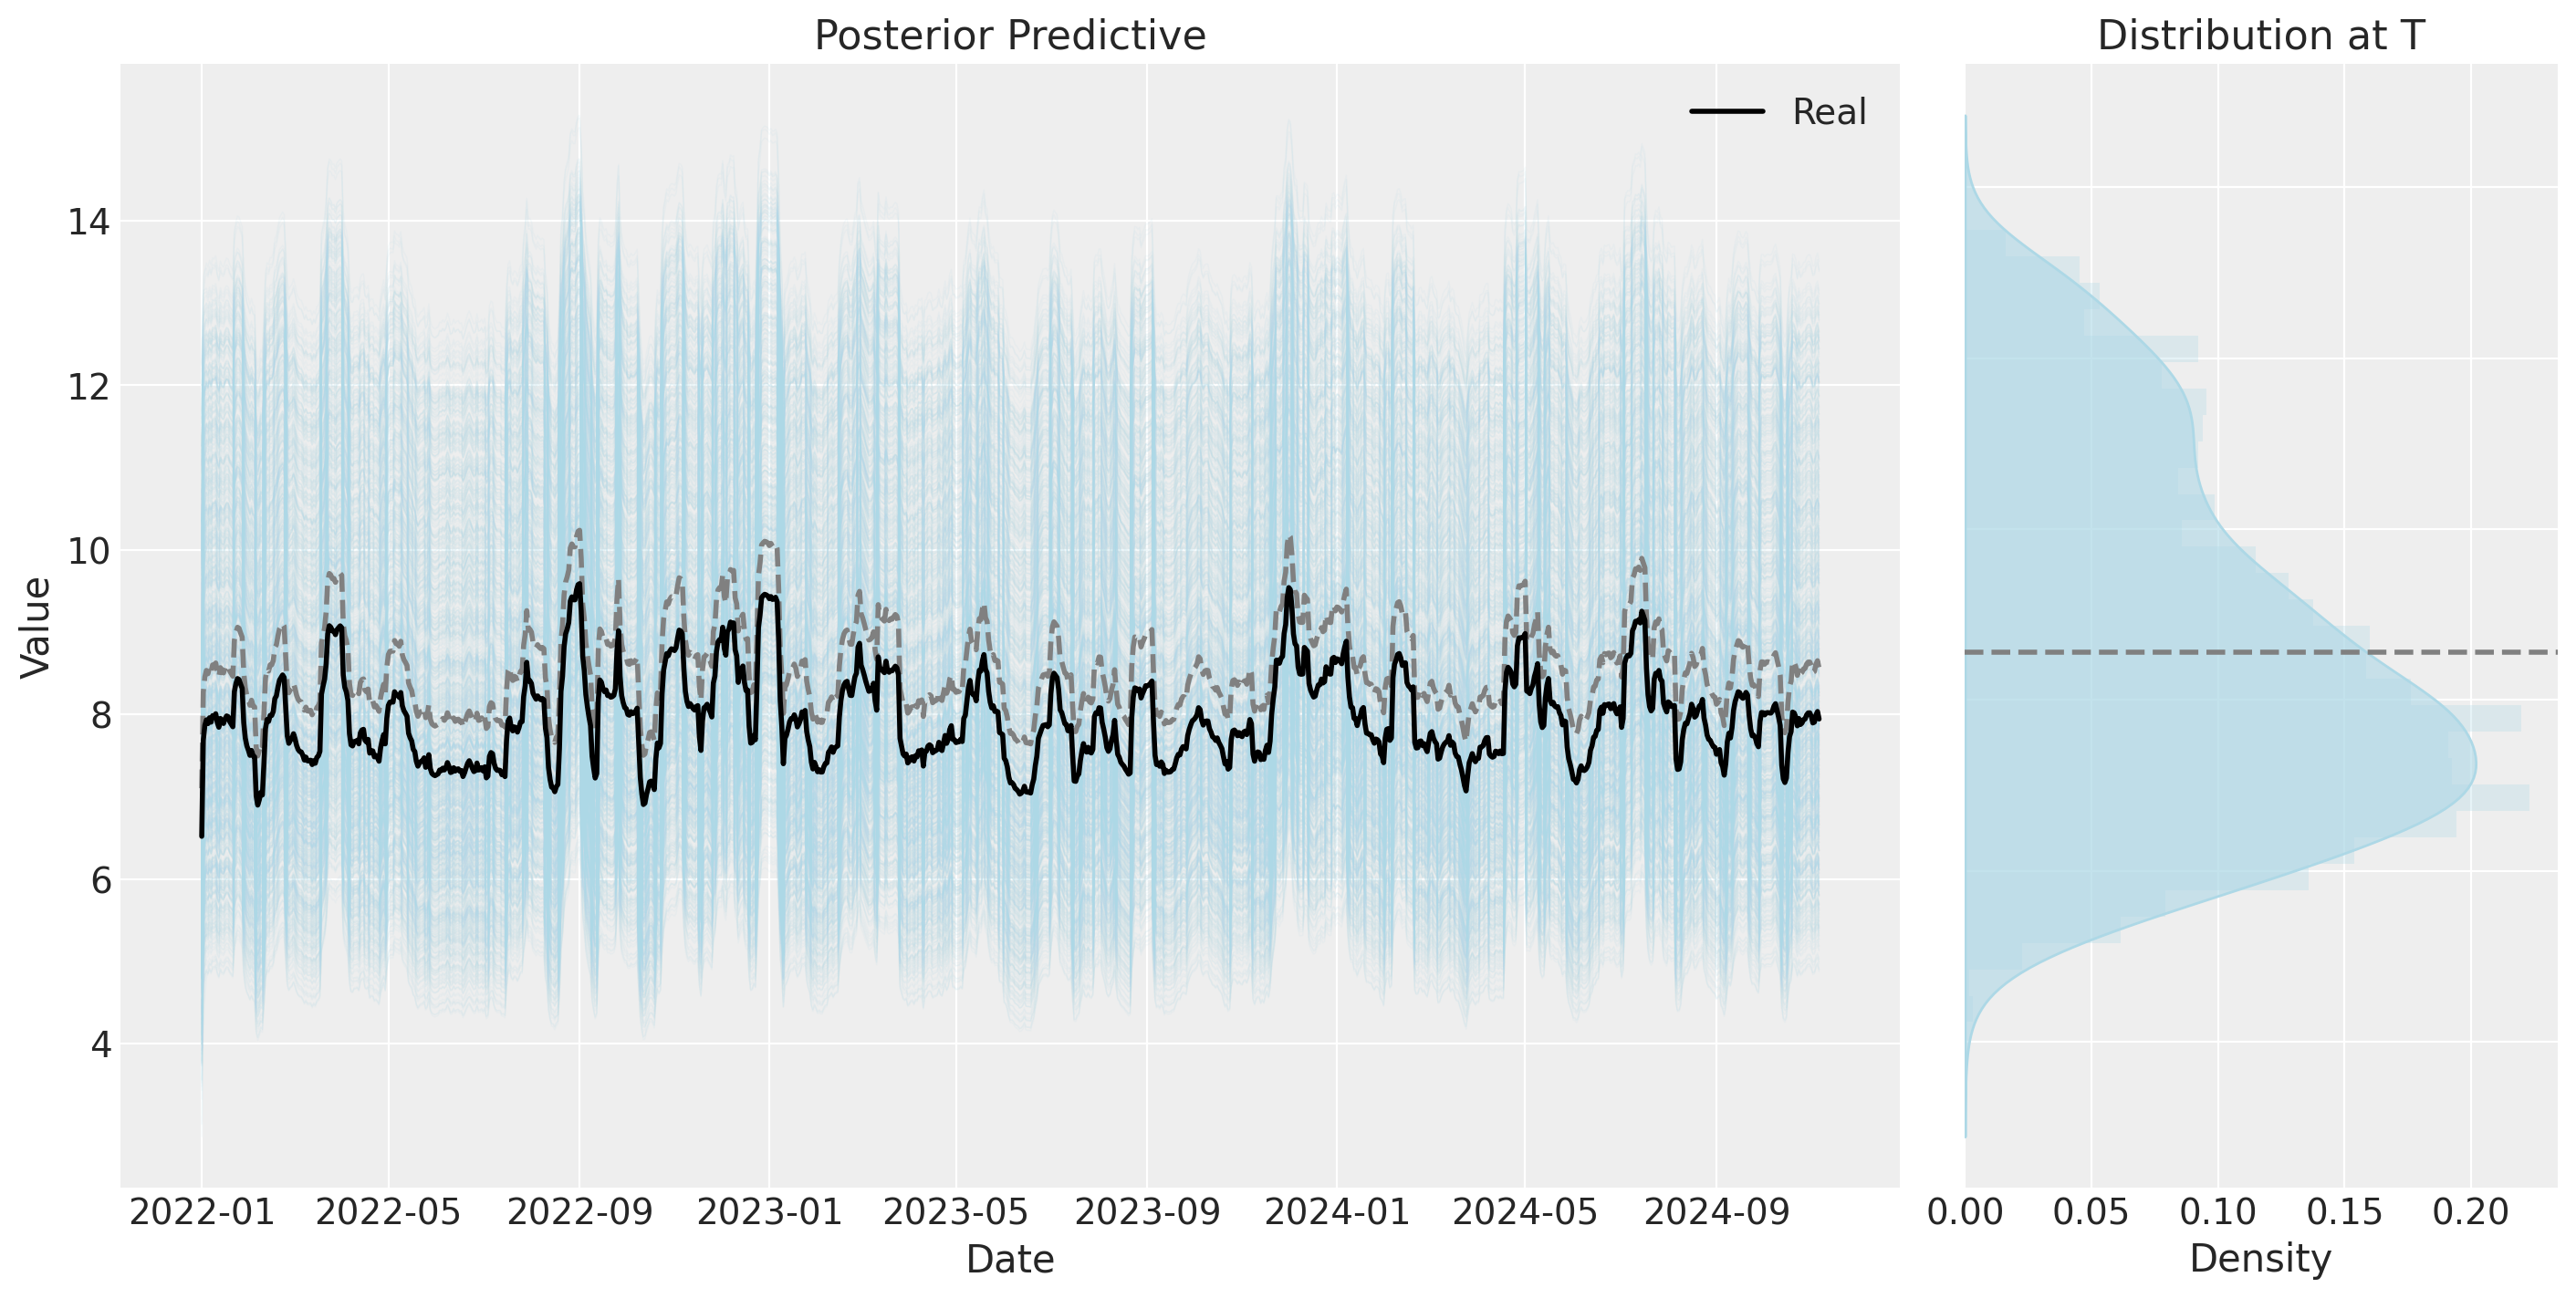

In [ ]:
plot_posterior(
    df["x3_adstock_saturated"].values,
    mmm.idata.posterior.channel_contribution.sel(channel="x3") * df["y"].max(),
    figsize=(14, 7),
    path_color='lightblue',
    hist_color='lightblue'
);

# What if we don't have some control varibales?

If we are confident in our data generative process we can be sure that by surgically excluding a node, a Gaussian process can absorb such variability.

In [ ]:
mmm = MMM(
    model_config=model_config,
    date_column="date",
    channel_columns=[
        "x1",
        "x2",
        # "x3"
    ],
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
    time_varying_intercept=True,
)

mmm.model_config["intercept_tvp_config"].ls_mu = 15
mmm.model_config["intercept_tvp_config"].m = 200
# mmm.model_config["intercept"] = Prior("Normal", mu=1, sigma=2)

mmm.fit(X, y, **fit_kwargs)
mmm.sample_posterior_predictive(
    X=X,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<xarray.Dataset> Size: 17MB
Dimensions:  (sample: 2000, date: 1041)
Coordinates:
  * date     (date) datetime64[ns] 8kB 2022-01-01 2022-01-02 ... 2024-11-06
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 17MB 9.857 9.433 10.26 ... 7.933 8.047 7.967
Attributes:
    created_at:                 2025-03-07T12:09:55.144877+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [ ]:
#summary of model idata
az.summary(mmm.idata, var_names=["saturation_alpha", "saturation_lam", "adstock_alpha",])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
saturation_alpha[x1]  0.139  0.022   0.104    0.183      0.002    0.001   
saturation_alpha[x2]  1.323  0.179   1.009    1.656      0.011    0.008   
saturation_lam[x1]    0.498  0.182   0.227    0.826      0.014    0.010   
saturation_lam[x2]    1.722  0.365   1.051    2.364      0.021    0.015   
adstock_alpha[x1]     0.508  0.036   0.437    0.572      0.002    0.001   
adstock_alpha[x2]     0.303  0.018   0.267    0.337      0.001    0.001   

                      ess_bulk  ess_tail  r_hat  
saturation_alpha[x1]     222.0     275.0   1.01  
saturation_alpha[x2]     252.0     350.0   1.01  
saturation_lam[x1]       217.0     266.0   1.01  
saturation_lam[x2]       274.0     381.0   1.01  
adstock_alpha[x1]        473.0     543.0   1.01  
adstock_alpha[x2]        652.0     882.0   1.00

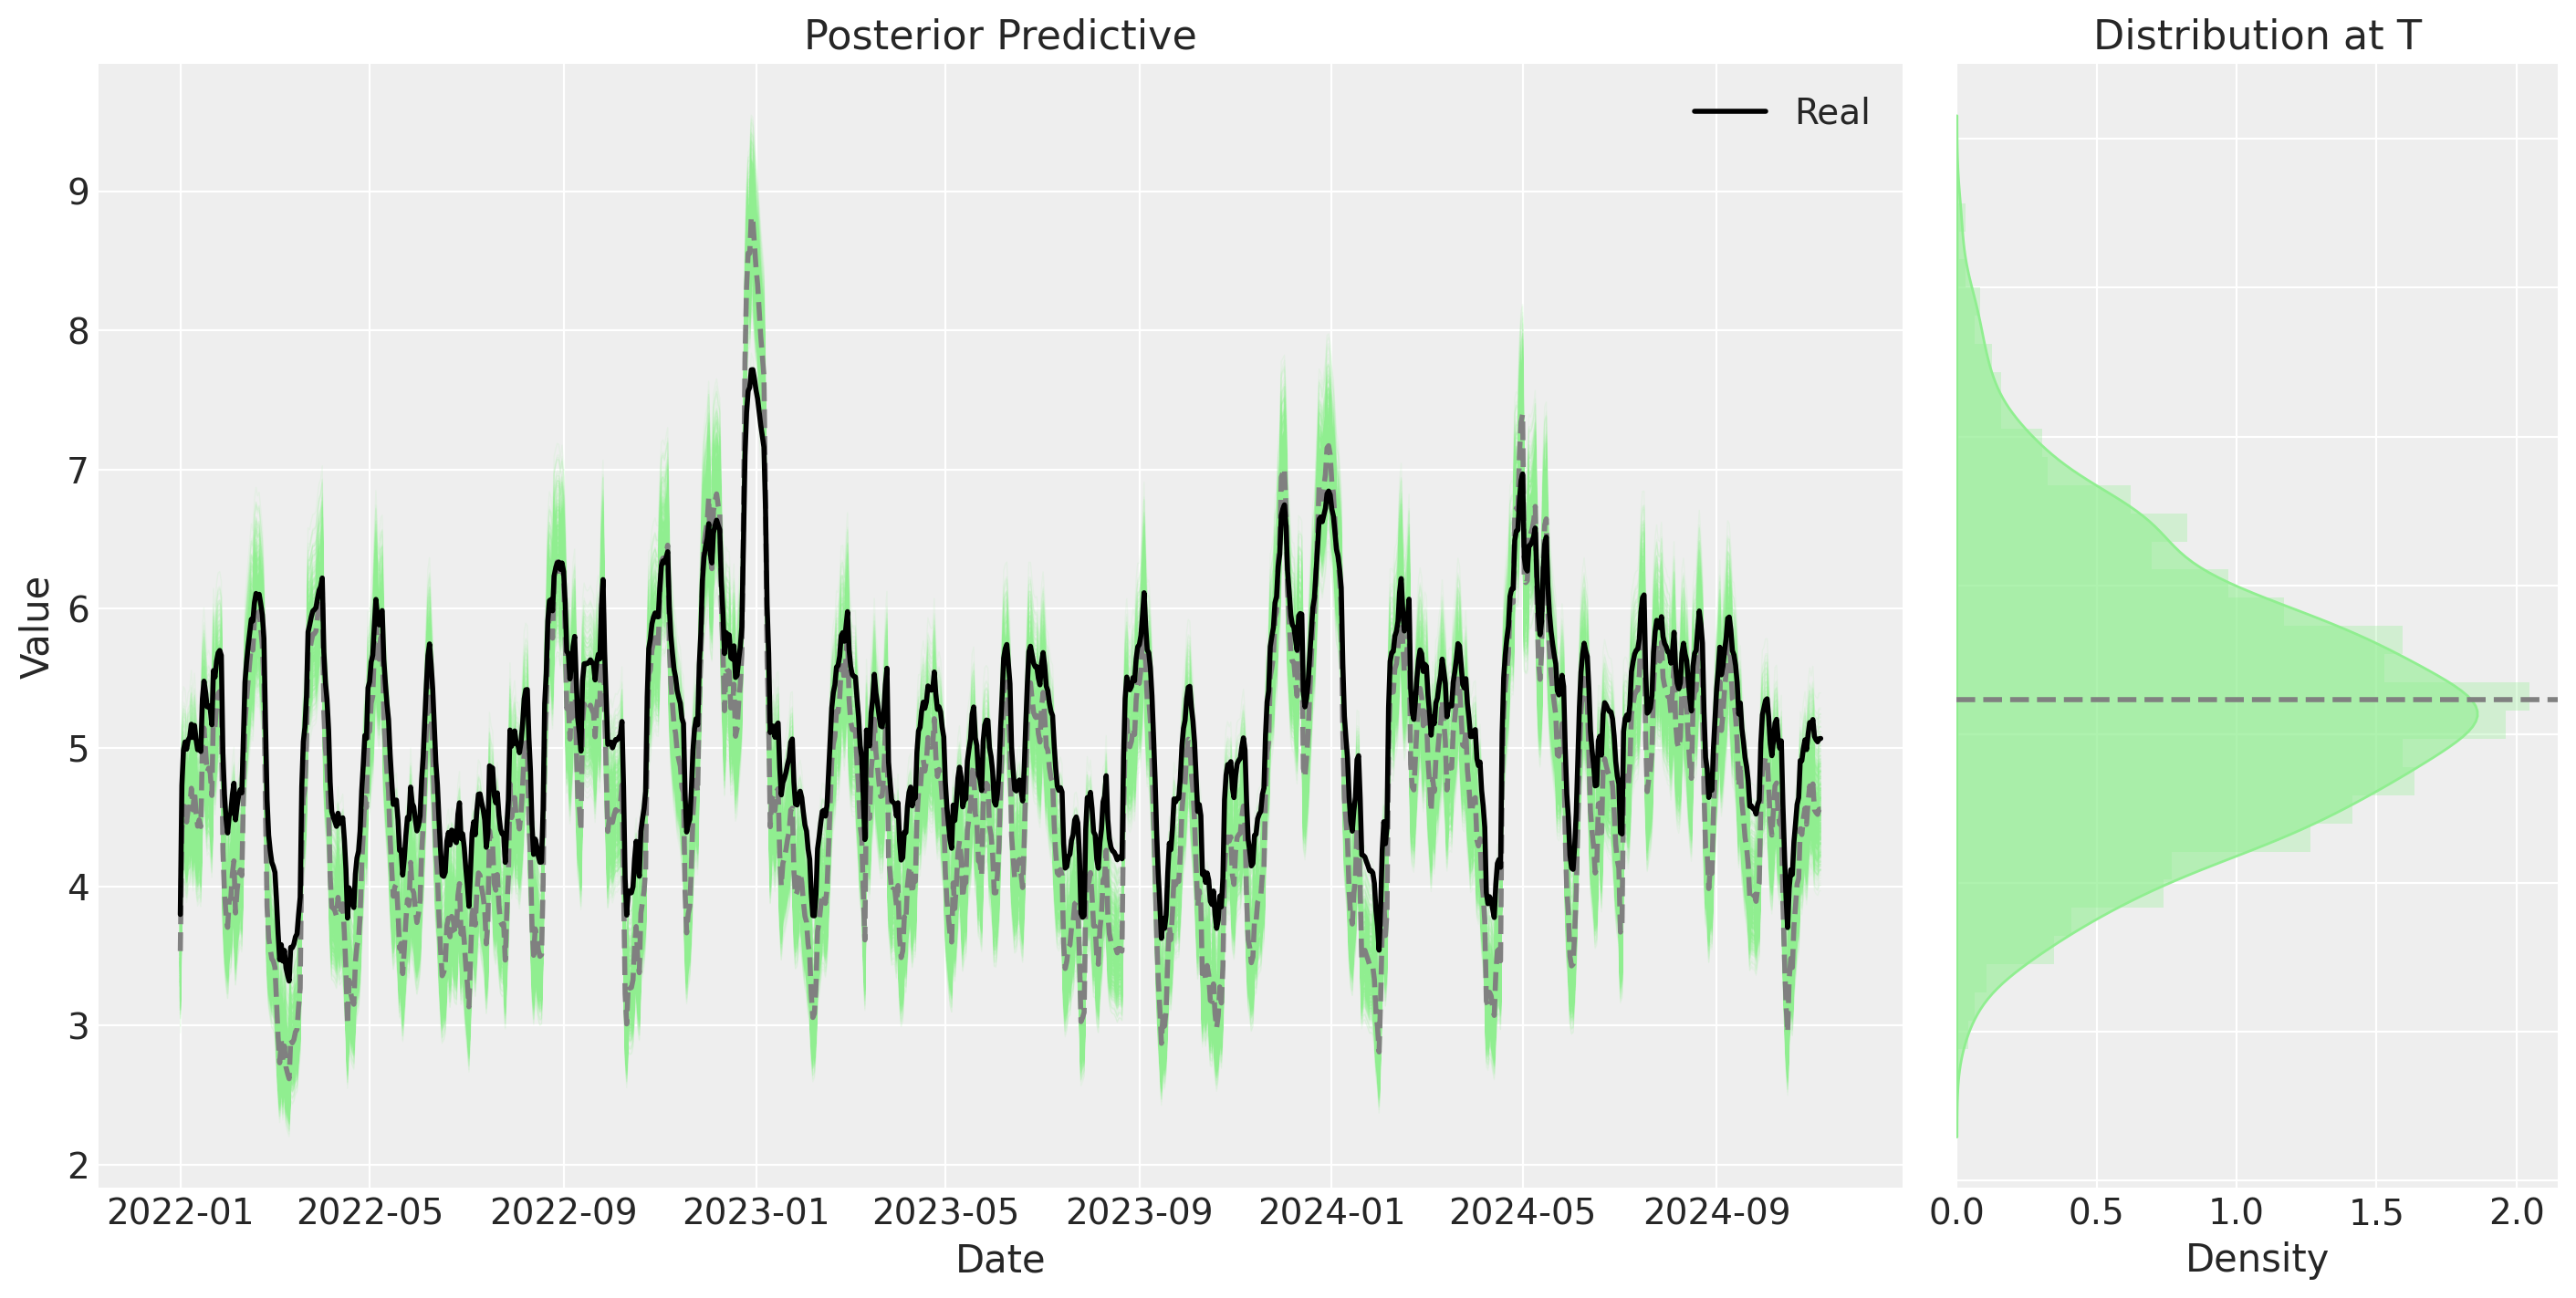

In [ ]:
plot_posterior(
    df["x2_adstock_saturated"].values,
    mmm.idata.posterior.channel_contribution.sel(channel="x2") * df["y"].max(),
    figsize=(14, 7),
    path_color='lightgreen',
    hist_color='lightgreen'
);

# key take aways

1. Don't seek the one single model: The real world is very dynamic, before its possible that the one single model it doesn't exist.

2. "Find" the Causal Truth: Dive into the world of causal structures and learn how to map out the hidden pathways that influence your outcomes. Not consider causal structures will drive you to consider more simple causal structures, which can be problematic in a real world enviroment.

3. Embrace Model Evolution: Don't get too attached to your first model! As we saw in our DAG progression, models can (and should) change as we learn more. Starting simple is fine, but be ready to level up your model game when the data shows there's more to the story.


# Our causal discovery process in a nutshell

<ipython-input-53-f23af147991b>:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


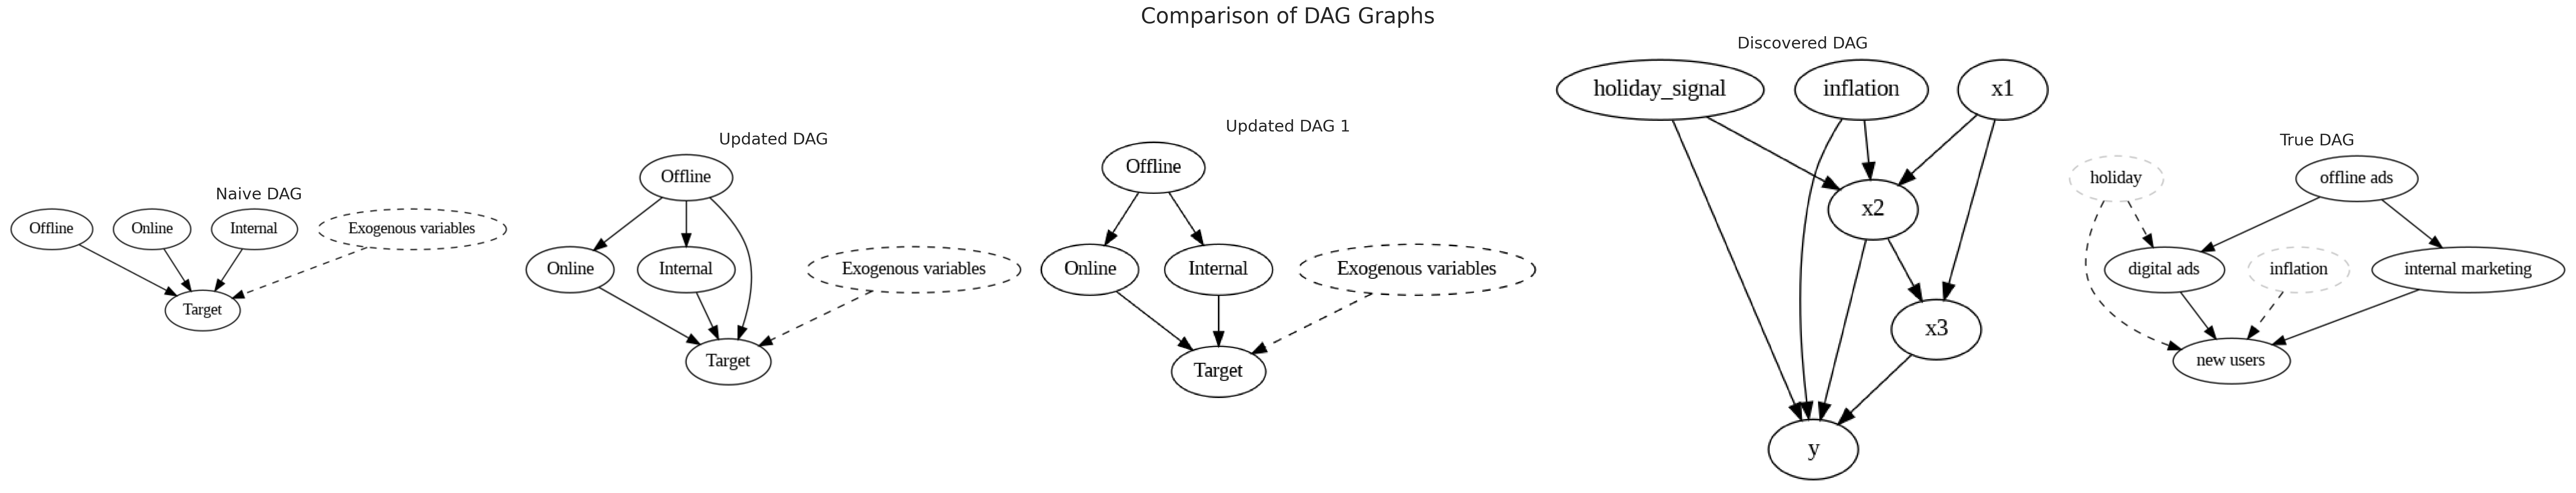

In [ ]:
# Create a figure with five subplots
fig, axes = plt.subplots(1, 5, figsize=(40, 8))

# Set titles for each subplot
titles = ["Naive DAG", "Updated DAG", "Updated DAG 1", "Discovered DAG", "True DAG"]
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=18)
    ax.axis('off')

# Render and plot each graph
naive_causal_mmm_graph.render(format='png', filename='naive_dag')
axes[0].imshow(mpimg.imread('naive_dag.png'))

updated_naive_causal_mmm_graph.render(format='png', filename='updated_dag')
axes[1].imshow(mpimg.imread('updated_dag.png'))

updated_naive_causal_mmm_graph1.render(format='png', filename='updated_dag1')
axes[2].imshow(mpimg.imread('updated_dag1.png'))

real_dag_graph = causal_model.to_graphviz(ges_graph)
real_dag_graph.render(format='png', filename='discovered_dag')
axes[3].imshow(mpimg.imread('discovered_dag.png'))

new_real_dag.render(format='png', filename='true_dag')
axes[4].imshow(mpimg.imread('true_dag.png'))

# Add main title
plt.suptitle("Comparison of DAG Graphs", fontsize=24)
plt.tight_layout()